# Python post-processing algorithm - Agilent & Thermo - Au - Version 1.0 - Steffen Hellmann & Dr. Teba Gil-Díaz

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics as stats
import math as math
import collections
from decimal import Decimal
from scipy.stats import norm
import scipy.stats as sps
from scipy.signal import find_peaks, argrelextrema
from math import log10, floor
def round_sig(x, sig=2):
    if math.isnan(x): return(math.nan)
    else: return round(x, sig-int(floor(log10(abs(x))))-1)
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
import csv
import os
import glob
import xlrd
import xlsxwriter
from scipy.signal import find_peaks
from PIL import Image # Change figure size in Excel
from matplotlib.transforms import Bbox, TransformedBbox, blended_transform_factory
from mpl_toolkits.axes_grid1.inset_locator import BboxPatch, BboxConnector,\
    BboxConnectorPatch
import ast

# !!!Update sample information!!!

In [49]:
#Data
d_std = 32.7 # in nm
p_p = 19.32 # particle density of gold in g/mL

instrument='Thermo' # Type in either 'Agilent' or 'Thermo'
dwell = 0.005 # Dwell/Integration time in s
flow_min = 0.010 # Sample inlet flow in ml/min
flow = flow_min / 60 # Sample inlet flow in ml/s
te = 0.58806 # Transport efficiency: Type in manually --> Results from "Gaussian: Particle number/frequency method" mostly µ+4-7SD check graphs
PNC_CRM = 1.47E+11 # Certified Particle Number concentration in particles/mL
DF = 4.627E+6 # Dilution factor for particle number, mass concentration; NOT for ionic concentration
response = 68740.075 # Slope of the ionic calibration curve in CPS/ppb
intercept = -3778.364 # CPS
total_aquisition_time = 120 # in s
f_d = 1 # Mass fraction e.g. M(SiO2)/M(Si) for Si as SiO2; for Au as Au = 1

# !!!Make sure only one '.csv' file is in the same folder as the code!!!

In [50]:
# Read file and name the path as "file"
file = glob.glob('*.csv')
new_file = file[0]
# Get File name of Excel file, replace ".xlsx" and save name
new_name = [s.replace('.csv', '') for s in file] # remove '.csv'
table = pd.read_csv(new_file, encoding='ISO-8859-1') # Original table

if instrument == 'Agilent':  # Ensure instrument is a string
    skip = len(table)  # last
    skip_1 = skip + 1
    skip_2 = skip + 2
    table = pd.read_csv(new_file,
                         skiprows=[0, 1, 2, skip, skip_1, skip_2])  # skip always last three rows
elif instrument == 'Thermo':  # Ensure instrument is a string
    table = pd.read_csv(new_file,
                         usecols=[1, 2],
                         skiprows=range(23966, 24357))  # skip data above 120 s
table

,Time 197Au,197Au
0,0.008,200.0016
1,0.013,0.0000
2,0.018,0.0000
3,0.023,0.0000
4,0.028,0.0000
...,...,...
23960,119.986,0.0000
23961,119.991,0.0000
23962,119.996,0.0000
23963,120.001,0.0000


In [51]:
# Select all data which are >0
table_wZeros = table[table[list(table.columns.values)[1]] >= 0]
table_OhneZeros = table[table[list(table.columns.values)[1]] > 0]
x = table_wZeros[list(table_wZeros.columns.values)[0]]
y = table_wZeros[list(table_wZeros.columns.values)[1]]

# Baseline correction & estimation of the ionic background via mode

Ionic mode estimation: 200.0016 cps


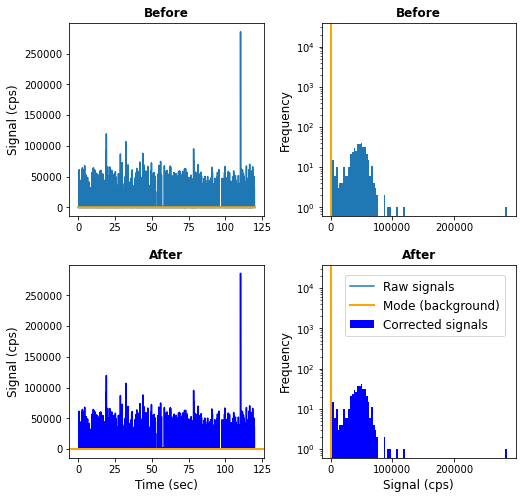

In [52]:
########## Indentifying the baseline ##########
# Static mode
ionic_mode_est = stats.mode(table_OhneZeros[list(table_OhneZeros.columns.values)[1]])
print('Ionic mode estimation: %s' % ionic_mode_est + ' cps')

# Moving mode  (has to be a panda series, but x and y are already, otherwise pd.Series(x) etc.)
y_series = y.rolling(100)

y_moving_modes = []
for _ in y_series:
    y_moving_modes.append(min(_))  #stats.mode(_) for the mode

anchor = np.ones(len(x))*stats.mean(y_moving_modes) # mean of mode values (background)

########## Correcting spectrogram for the baseline ##########
y_corr = y.subtract(pd.Series(y_moving_modes))
y_corr = y_corr.add(pd.Series(anchor))

# Let's see how it looks like
figure, axis = plt.subplots(2,2,figsize=(8,8)) 
figure.subplots_adjust(hspace=0.25, wspace=0.3)
axis[0,0].plot(x, y, label='Raw signals')
axis[0,0].plot(x, np.ones(len(x))*ionic_mode_est, linewidth=2, color='orange')

axis[0,1].hist(y, bins = 100, log=True, label="Raw signals")
axis[0,1].axvline(ionic_mode_est, color='orange', linewidth=2, label='Mode (background)')

axis[1,0].plot(x, y_corr, color='b')
axis[1,0].axhline(ionic_mode_est, color='orange', linewidth=2)

axis[1,1].hist(y_corr, bins = 100, log=True, color='b', label="Corrected signals")
axis[1,1].axvline(ionic_mode_est, color='orange', linewidth=2)

axis[0,0].set_title('Before', fontsize=12, fontweight='semibold')
axis[0,1].set_title('Before', fontsize=12, fontweight='semibold')
axis[1,0].set_title('After', fontsize=12, fontweight='semibold')
axis[1,1].set_title('After', fontsize=12, fontweight='semibold')
axis[1,0].set_xlabel('Time (sec)', fontsize=12)
axis[1,1].set_xlabel('Signal (cps)', fontsize=12)
axis[1,0].set_ylabel('Signal (cps)', fontsize=12)
axis[0,0].set_ylabel('Signal (cps)', fontsize=12)
axis[0,1].set_ylabel('Frequency', fontsize=12)
axis[1,1].set_ylabel('Frequency', fontsize=12)

#plt.annotate('n=%s' %sum(~np.isnan(raw_data_Au['Au_0.1_ms_sizes_MassHunter_Agilent_(nm)_2'])), xy=(-0.425, -5), fontsize=15)
####!!!!!!!Set a legend manually!!!!!!!!!#####
legend_elements = [axis[0,0].get_legend_handles_labels()[0][0],              
                   axis[0,1].get_legend_handles_labels()[0][0],
                   axis[1,1].get_legend_handles_labels()[0][0]]
plt.legend(handles=legend_elements, loc=[0.12,0.63], fontsize=12)
# Save figure
plt.savefig(new_name[0] + "_baseline_correction" + ".png", bbox_inches='tight', dpi=300)

########## Reconverting into a format that the rest of the code can use without any other changes ##########
tuple_d = []
for i in range(len(x)):
    tuple_d.append([x[i],y_corr[i]])
    
new_table_wZeros = pd.DataFrame((tuple_d),columns=['Time [Sec]','Element [cps]'])
new_table_OhneZeros = new_table_wZeros[new_table_wZeros[list(new_table_wZeros.columns.values)[1]] > 0]

table1=new_table_OhneZeros
table=new_table_wZeros

# Iteration (40 times) or clear cut function to get particle detection thresholds (Gaussian)

In [53]:
#Collecting TableX and iterating to obtain optimal PDT values
#for the mean part
def o_mean_sig_perX(tableX,i):
    mean = np.mean(tableX.iloc[:, 1])
    sd = np.std(tableX.iloc[:, 1])
    value = mean + i*sd
    return value

#for the a part
def a_meanX(tableX,mean_sig_X):
    shortened_tables = tableX[tableX.iloc[:, 1] < mean_sig_X]
    return shortened_tables

################ Fuction to identify a clear cut in the histograms (good for millisecond dwell times) ################
def clear_cut(tableX):
    x = np.histogram(tableX.iloc[:, 1], bins=100)
    i = 0
    for key in x[1][:-1]:
        if x[0][i] == 0:
            cps = key
            break
        i += 1
    return cps

# Then run the iterations for the given SD trials
sd_trials = [3,4,5,6,7]        # This is "X"
tableX_dict = {}
PDT_list = []

guide = clear_cut(table1)

for i in sd_trials:
    tableX = table1
    name = 'PDT{}'.format(i)   # 'PDT{}'.format(value that will be written inside{}) ==> outputs: PDT3, PDT4, etc.
    
    for count in np.arange(0,40): # For 40 iterations
        meanANDsig = o_mean_sig_perX(tableX,i) 
        a_res = a_meanX(tableX,meanANDsig)
        
        if count == 35 and meanANDsig > guide:
            meanANDsig = guide
            a_res = a_meanX(tableX,guide)
            break
        
        if np.isnan(meanANDsig) == False and len(a_res) == 0:
            meanANDsig = meanANDsig_previous
            a_res = a_meanX(tableX,meanANDsig_previous)
            break

        tableX = a_res
        meanANDsig_previous = meanANDsig
        
    PDT_list.append((name,meanANDsig))
    tableX_dict['tableX{}'.format(i)] = tableX

# print('This is the %s th iteration' %count)
for p in range(len(PDT_list)):
    print('The Particle Detection Threshold (µ + {}SD) is:  '.format(sd_trials[p]), np.around(PDT_list[p][1]))

# Save as variables    
PDT3 = PDT_list[0][1]
PDT4 = PDT_list[1][1]
PDT5 = PDT_list[2][1]
PDT6 = PDT_list[3][1]
PDT7 = PDT_list[4][1]

The Particle Detection Threshold (µ + 3SD) is:   226.0
The Particle Detection Threshold (µ + 4SD) is:   293.0
The Particle Detection Threshold (µ + 5SD) is:   421.0
The Particle Detection Threshold (µ + 6SD) is:   500.0
The Particle Detection Threshold (µ + 7SD) is:   578.0


# Calculation of background (average/mode) from the whole dataset below PDT (Gaussian)

In [54]:
###### Calculation of ionic background (average/mode) from the whole dataset < PDT = for Gaussian method
def mean_mode_ionic(tableX_name,i):
    name = 'mean_and_mode_ionic_cps_{}'.format(i)
    res_mean = np.mean(tableX_name[tableX_name.keys()[1]])    # Call the values inside the dictionary for the key "element" and not the "time"
    res_mode = stats.mode(tableX_name[tableX_name.keys()[1]]) # tableX_name[tableX_name] includes all values below PDT (background)
    return name,res_mean,res_mode     

mean_mode_ionic_cps_list = []

for i in sd_trials:
    tableX_i = tableX_dict['tableX{}'.format(i)]    # Table with values below PDT (all); tableX (with "zeros")   
    mean_mode_ionic_res = mean_mode_ionic(tableX_i,i)
    mean_mode_ionic_cps_list.append(mean_mode_ionic_res)

# To call the values inside the dictionary = tableY_dict['tableY5']['Au197'])) -> for original dict
# To identify which key it is in = tableY_dict['tableY5'].keys()[1] -> for original dict
# for the new dictionaries = table_minus_bckg['tableY3']

#mean_mode_ionic_cps_list["0=µ+3SD;1=µ+4SD; ...; 4=µ+7SD"][0=name;1=mean;2=mode]  ;  e.g. for mode µ + 3SD --> mean_mode_ionic_cps_list[0][2]

# Particle detection threshold and critical value (Poisson)

In [55]:
##### Critical value (LC) is the baseline from where the integration should start
##### PDT_poisson is the detection limit when a particle will be considered as particle
## Teba's comment: mean_ionic_cps_list[p][1] corresponds to "ojímetro method" from Oviedo ;)
###ATTENTION: poisson calculations are defined only for the MEAN!! adapt for MODE if required

def Poisson_method(i):
    name = 'Poisson_LC_and_PDT_{}'.format(i)
    p = i-sd_trials[0]
    LC_poisson = np.mean(table[list(table.columns.values)[1]]) + (2.33 * (np.mean(table[list(table.columns.values)[1]]) * dwell + e)**(1/2)) / dwell # Takes the whole average of all data
    #LC_poisson = (2.33 * ((mean_mode_ionic_cps_list_poisson[p][1] * dwell + e)**(1/2))) / dwell # Takes the the background average of the data

    PDT_poisson = np.mean(table[list(table.columns.values)[1]]) + 2.71 + 4.65 * ((np.mean(table[list(table.columns.values)[1]]) * dwell + e)**(1/2)) / dwell # Takes the whole average of all data
    #PDT_poisson = 2.71 + 4.65 * ((mean_mode_ionic_cps_list_poisson[p][1] * dwell + e)**(1/2)) / dwell # Takes the the background average of the data

    return name,LC_poisson,PDT_poisson
poisson_limits = []
for i in sd_trials[0:1]:
    p = i-sd_trials[0]
    if mean_mode_ionic_cps_list[p][1] < 5/dwell:    
        e = 0.5         ##### For low background correction term 0.5 otherwise 0
    else:
        e = 0
    poisson_limits.append(Poisson_method(i))
    print('Critical value (LC) (Poisson) [CPS] = %s'.format(i) % poisson_limits[i-3][1])
    print('Particle detection threshold (Poisson) [CPS] = %s'.format(i) % poisson_limits[i-3][2])

# The Baseline should be the critical value (LC_poisson)???

Critical value (LC) (Poisson) [CPS] = 1808.7480388256176
Particle detection threshold (Poisson) [CPS] = 2802.868731246005


# Calculation of background (average/mode) from the whole dataset below PDT (Poisson)

In [56]:
###### Calculation of ionic background (average/mode) from the whole dataset < PDT = for Poisson method
mean_mode_ionic_cps_list_poisson = []

for i in sd_trials[0:1]:
    tableX_i = table1[table1.iloc[:, 1] < poisson_limits[i-3][2]]
    mean_mode_ionic_cps_list_poisson.append(mean_mode_ionic(tableX_i,i))

# Plot all data and show PDT to choose the best PDT (Gaussian)

<ipython-input-57-ec3eaa1118ea>:63: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_ = plt.subplot(grid[q])
<ipython-input-57-ec3eaa1118ea>:76: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax__ = plt.subplot(grid[q+5])
<ipython-input-57-ec3eaa1118ea>:92: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will alway

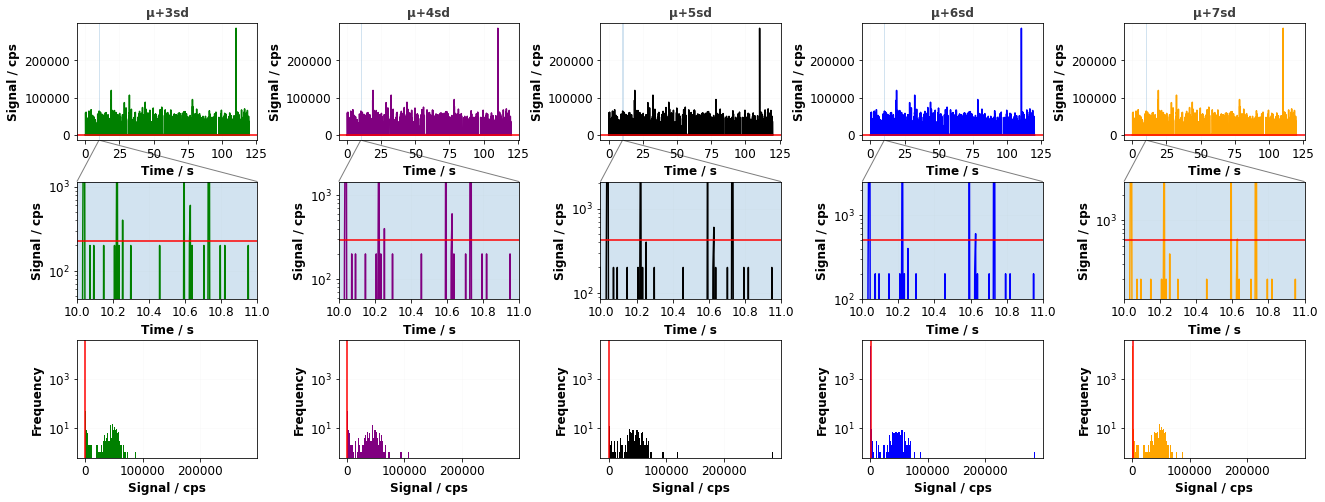

In [57]:
# For the zoom function
def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = prop_lines.copy()
        prop_patches["alpha"] = prop_patches.get("alpha", 1)*0.2
    c1 = BboxConnector(bbox1, bbox2, alpha=0.5, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(bbox1, bbox2, alpha=0.5, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)
    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)
    p = BboxConnectorPatch(bbox1, bbox2,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           **prop_patches)
    p.set_clip_on(False)
    return c1, c2, bbox_patch1, bbox_patch2, p

def zoom_effect02(ax1, ax2, **kwargs):
    """
    ax2 : the big main axes
    ax1 : the zoomed axes
    The xmin & xmax will be taken from the
    ax1.viewLim.
    """
    tt = ax1.transScale + (ax1.transLimits + ax2.transAxes)
    trans = blended_transform_factory(ax2.transData, tt)
    mybbox1 = ax1.bbox
    mybbox2 = TransformedBbox(ax1.viewLim, trans)
    prop_patches = kwargs.copy()
    prop_patches["ec"] = "none"
    prop_patches["alpha"] = 0.2
    c1, c2, bbox_patch1, bbox_patch2, p = \
        connect_bbox(mybbox1, mybbox2,
                     loc1a=2, loc2a=3, loc1b=1, loc2b=4, 
                     prop_lines=kwargs, prop_patches=prop_patches)
    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)
    return c1, c2, bbox_patch1, bbox_patch2, p

# Plot function
fig, ax = plt.subplots(figsize=(22,8))
rows = 3
columns = 5

#Is needed that you can have more than 9 subplots
grid = plt.GridSpec(rows, columns, wspace = .45, hspace = .35)
for i in range(rows*columns):
    exec (f"plt.subplot(grid{[i]})")

color_list = ['green', 'purple', 'k', 'blue', 'orange']
    
#Subplot definitions
for p in sd_trials:
    q = p-sd_trials[0]    
    
    # Full Scale (Gaussian µ + kSD)   
    ax_ = f'ax{q+1}'
    ax_ = plt.subplot(grid[q])

    plt.plot(table1[list(table1.columns.values)[0]], table1[list(table1.columns.values)[1]], color=color_list[q])
    plt.title(f'µ+{p}sd', fontweight='semibold', alpha=0.75)
    plt.xlabel('Time / s', fontsize=12, fontweight='semibold')
    plt.ylabel('Signal / cps', fontsize=12, fontweight='semibold')
    plt.grid(alpha=0.05)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axhline(y = PDT_list[q][1] , color='red')

    # Zoom (Gaussian µ + kSD)
    ax__ = f'ax{q+1}'
    ax__ = plt.subplot(grid[q+5]) 
 
    zoom_effect02(ax__, ax_)
    plt.plot(table1[list(table1.columns.values)[0]], table1[list(table1.columns.values)[1]], color=color_list[q])
    plt.yscale('log')
    plt.xlabel('Time / s', fontsize=12, fontweight='semibold')
    plt.ylabel('Signal / cps', fontsize=12, fontweight='semibold')
    plt.grid(alpha=0.05)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axhline(y = PDT_list[q][1] , color='red')
    plt.ylim(((round_sig(int(PDT_list[q][1])))/5), (round_sig(int(PDT_list[q][1])))*5) # Zoom on y axis
    plt.xlim([10,11]) # Zoom on x axis
    
    # Histogram before peak integration (Gaussian µ+kSD)
    ax___ = f'ax{q+11}'
    ax___ = plt.subplot(grid[q+10]) 

    plt.hist(table1[list(table1.columns.values)[1]], bins=500, alpha=1, color=color_list[q], label=f'Histogram PDT{p}')
    plt.yscale('log')
    plt.xlabel('Signal / cps', fontsize=12, fontweight='semibold')
    plt.ylabel('Frequency', fontsize=12, fontweight='semibold')
    plt.grid(alpha=0.05)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axvline(x = PDT_list[q][1], ymin=[0], ymax=[1], color='red')

# Save figure
plt.savefig(new_name[0] + "_time_zoom_gaussian" + ".png", bbox_inches='tight', dpi=300)

# Calculation of background (average/mode) from the whole dataset below PDT (Gaussian)

In [58]:
###### Calculation of ionic background (average/mode) from the whole dataset < PDT = for Gaussian method
def mean_mode_ionic(tableX_name,i):
    name = 'mean_and_mode_ionic_cps_{}'.format(i)
    res_mean = np.mean(tableX_name[tableX_name.keys()[1]])    # Call the values inside the dictionary for the key "element" and not the "time"
    res_mode = stats.mode(tableX_name[tableX_name.keys()[1]]) # tableX_name[tableX_name] includes all values below PDT (background)
    return name,res_mean,res_mode     

mean_mode_ionic_cps_list = []

for i in sd_trials:
    tableX_i = tableX_dict['tableX{}'.format(i)]    # Table with values below PDT (all); tableX (with "zeros")   
    mean_mode_ionic_res = mean_mode_ionic(tableX_i,i)
    mean_mode_ionic_cps_list.append(mean_mode_ionic_res)

# To call the values inside the dictionary = tableY_dict['tableY5']['Au197'])) -> for original dict
# To identify which key it is in = tableY_dict['tableY5'].keys()[1] -> for original dict
# for the new dictionaries = table_minus_bckg['tableY3']

#mean_mode_ionic_cps_list["0=µ+3SD;1=µ+4SD; ...; 4=µ+7SD"][0=name;1=mean;2=mode]  ;  e.g. for mode µ + 3SD --> mean_mode_ionic_cps_list[0][2]

# Plot all data and show PDT to choose the best PDT (Poisson)

<ipython-input-59-6878e60635e5>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(grid[0])
<ipython-input-59-6878e60635e5>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot(grid[1]) # Zoom
<ipython-input-59-6878e60635e5>:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will a

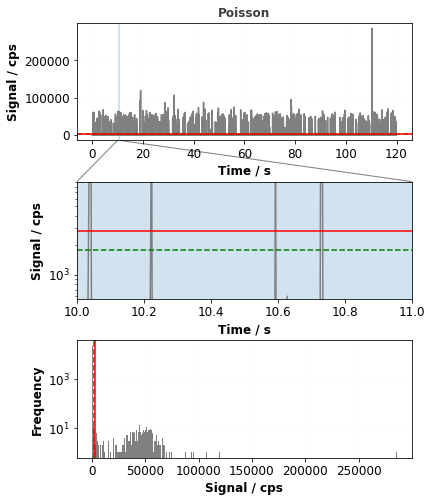

In [59]:
# Plot function
fig, ax = plt.subplots(figsize=(6,8))
rows = 3
columns = 1
#Is needed that you can have more than 9 subplots
grid = plt.GridSpec(rows, columns, wspace = .4, hspace = .35)
for i in range(rows*columns):
    exec (f"plt.subplot(grid{[i]})")
# Full scale (Poisson)
ax1 = plt.subplot(grid[0])
plt.plot(table1[list(table1.columns.values)[0]], table1[list(table1.columns.values)[1]], color='gray')
plt.title('Poisson', fontweight='semibold', alpha=0.75)
plt.xlabel('Time / s', fontsize=12, fontweight='semibold')
plt.ylabel('Signal / cps', fontsize=12, fontweight='semibold')
plt.grid(alpha=0.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y = poisson_limits[0][1] , color='green', ls ='--') # Lc
plt.axhline(y = poisson_limits[0][2] , color='red') # Ld

# Zoom (Poisson)
ax2 = plt.subplot(grid[1]) # Zoom
zoom_effect02(ax2, ax1)
plt.plot(table1[list(table1.columns.values)[0]], table1[list(table1.columns.values)[1]], color='gray')
plt.yscale('log')
plt.xlabel('Time / s', fontsize=12, fontweight='semibold')
plt.ylabel('Signal / cps', fontsize=12, fontweight='semibold')
plt.grid(alpha=0.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y = poisson_limits[0][1] , color='green', ls ='--') # Lc
plt.axhline(y = poisson_limits[0][2] , color='red') # Ld
plt.ylim(((round_sig(int(poisson_limits[0][2])))/5), (round_sig(int(poisson_limits[0][1])))*5) # Zoom on y axis
plt.xlim([10,11]) # Zoom on x axis

# Histogram before peak integration (Poisson)
ax3 = plt.subplot(grid[2]) # Zoom
plt.hist(table1[list(table1.columns.values)[1]], bins=500, alpha=1, color='gray', label='Histogram PDT (Poisson)')
plt.yscale('log')
plt.xlabel('Signal / cps', fontsize=12, fontweight='semibold')
plt.ylabel('Frequency', fontsize=12, fontweight='semibold')
plt.grid(alpha=0.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axvline(x = poisson_limits[0][1], ymin=[0], ymax=[1], color='green', ls ='--') # Lc
plt.axvline(x = poisson_limits[0][2], ymin=[0], ymax=[1], color='red') # Ld

# Save figure
plt.savefig(new_name[0] + "_time_zoom_poisson" + ".png", bbox_inches='tight', dpi=300)

# Peak integration (Gaussian)

In [60]:
### Peak integration based on two approaches and PDT as background levels #### [with zeros]

tableY_cps = list(table.iloc[:,1])
All_peak_sums = []
All_ionic_signal_list = [] # values (ionic signal - ionic mean values) for the plot
corr_background = [] # This is needed as we substract the background mean from every signal --> Therefore we also need to substract the background mean from each PDT for the plot!!!

for i in sd_trials:
    background = round(PDT_list[i-3][1],1)  # PDT from Gaussian approach (iterations)
    peak_sums_list = []
    ionic_signal_list = []
    real_position_o = 0
    peak_events_o = 0
    delta_o = 0
    peak = 0
    corr_background.append(background - mean_mode_ionic_cps_list[i-3][1]) # "New" PDT's for the plots!
    
    while real_position_o < len(tableY_cps)-1:
#         print("position = " + str(real_position_o) + " value of raw cps = " + str(round(tableY_cps[real_position_o],0)))
        delta_o = 0
        
        if tableY_cps[real_position_o] >= background:
            peak_events_o += 1
            peak = 0    
            
            if tableY_cps[real_position_o+1] < background:
                peak = tableY_cps[real_position_o] - mean_mode_ionic_cps_list[i-3][1]   # This goes to the peak not to the background
                #print("position = " + str(real_position_o), tableY_cps[real_position_o], peak)

                if peak < 0.0:
                    print("too high ionic background correction -> negative cps to the peak contribution") 
                
            else: 
                if dwell >= 0.002:
                    peak = tableY_cps[real_position_o] - mean_mode_ionic_cps_list[i-3][1]
                    
                else:
                    while tableY_cps[real_position_o+delta_o] >= background and delta_o < 1000:
                        peak += tableY_cps[real_position_o+delta_o] - mean_mode_ionic_cps_list[i-3][1]
#                         print("position = " + str(real_position_o), delta_o, round(tableY_cps[real_position_o+delta_o],0), round(peak,0))
                        delta_o += 1

                        if delta_o == 999:
                            print("need more range in scoping")
                            break     
                            
                        if real_position_o+delta_o >= len(tableY_cps):
                            print("reached the end of the dataset")
                            break  
                    delta_o = delta_o - 1
                    
            peak_sums_list.append(int(peak))
        
        else:
            if tableY_cps[real_position_o] != 0.0:
                ionic_signal_list.append(tableY_cps[real_position_o]) # here is where you have the background cps without removal of mean ionic signal
        
        real_position_o += 1 + delta_o       
    
    All_peak_sums.append(peak_sums_list)
    All_ionic_signal_list.append(ionic_signal_list) # Ionic background
    
#TAKE DATA FROM
#All_peak_sums --> Take particle Data from here
#All_ionic_signal_list --> Take background/ionic data from here

# Peak integration (Poisson)

In [61]:
### Peak integration based on two approaches and PDT as background levels #### [with zeros]

#tableY_time = list(table.iloc[:,0])
tableY_cps = list(table.iloc[:,1])

All_peak_sums_poisson = []
All_ionic_signal_list_poisson = []  # real values without substraction (ionic signal - ionic mean values)
corr_background_poisson = []

for i in sd_trials[0:1]:
    background_LD = round(poisson_limits[i-3][2],1)   # Particle detection threshold
    background_LC = round(poisson_limits[i-3][1],1)   # Critical value
    peak_sums_list_poisson = []
    ionic_signal_list_poisson = []
    real_position_o_poisson = 0
    peak_events_o_poisson = 0
    corr_background_poisson.append(background_LD - background_LC) # Background minus mean (background) --> Corrected poisson limits (PDT's)
    
    # First checks if cps are above LC. Then checks if the next cps are also above the LD. Only then, we account for particle event. If not, all is ionic.
    #print("LC = " + str(background_LC) + " and LD = " + str(background_LD))
    
    while real_position_o_poisson < len(tableY_cps)-1:        
        #print("position = " + str(real_position_o_poisson) + ", value = " + str(tableY_cps[real_position_o_poisson]))
        delta_o = 0
        peak_poisson = 0
        
        if tableY_cps[real_position_o_poisson] >= background_LC:                
                
            if tableY_cps[real_position_o_poisson] >= background_LD:
#                print("position = " + str(real_position_o_poisson) + ", value = " + str(tableY_cps[real_position_o_poisson]) + " > " + str(background_LD))
                peak_events_o_poisson += 1
                     
                if dwell >= 0.002:
                    peak_poisson = tableY_cps[real_position_o_poisson] - mean_mode_ionic_cps_list_poisson[i-3][1]
                    #for 5ms we don't account for peaks between LC and LD
                
                else:
                    standing_peak = tableY_cps[real_position_o_poisson] - mean_mode_ionic_cps_list_poisson[i-3][1]
                    #print("values in play = " + str(tableY_cps[real_position_o_poisson-2]) + ", " + str(tableY_cps[real_position_o_poisson-1]) + " < " + str(tableY_cps[real_position_o_poisson]) + " > " + str(tableY_cps[real_position_o_poisson+1]) + ", " + str(tableY_cps[real_position_o_poisson+2]))
                    
                    if tableY_cps[real_position_o_poisson-1] >= background_LC:
                        delta_i = 1
                        while tableY_cps[real_position_o_poisson-delta_i] >= background_LC and delta_i < 1000:
                            standing_peak += tableY_cps[real_position_o_poisson-delta_i] - mean_mode_ionic_cps_list_poisson[i-3][1]
                            delta_i +=1
                            
                            if delta_i == 999:
                                print("need more range in backwards scoping")
                                break 
                                
                        #print("pre-preak added = " + str(standing_peak))
                        
                    if tableY_cps[real_position_o_poisson+1] < background_LC:
                        peak_poisson = standing_peak 
                        #print("end of standing peak") 

                    else:    
                        delta_o = 1
                        
                        while tableY_cps[real_position_o_poisson+delta_o] >= background_LC and delta_o < 1000:
                            standing_peak += tableY_cps[real_position_o_poisson+delta_o] - mean_mode_ionic_cps_list_poisson[i-3][1]
                            #print("delta = " + str(delta_o) + ", value = " + str(standing_peak))
                            delta_o += 1
                            
                            if delta_o == 999:
                                print("need more range in scoping")
                                break           
                        peak_poisson = standing_peak 
                        delta_o = delta_o - 1
                        
                peak_sums_list_poisson.append(int(peak_poisson))
                #print(peak_sums_list_poisson)
        else:
            if tableY_cps[real_position_o_poisson] != 0.0:            
                ionic_signal_list_poisson.append(tableY_cps[real_position_o_poisson])   #Calculation of ionic background

        real_position_o_poisson += 1 + delta_o 
        

    All_peak_sums_poisson.append(peak_sums_list_poisson)
    All_ionic_signal_list_poisson.append(ionic_signal_list_poisson) # Calculation of ionic background

#TAKE DATA FROM
#All_peak_sums_poisson --> Take particle Data from here
#All_ionic_signal_list_poisson --> Take background/ionic data from here

# Convert data from list into pandas dataframe & calculate ionic concentration (Gaussian)

In [62]:
### Ionic data from here
def dataframe_particle_ionic_mode(i):
    name = 'particle_ionic_mode_{}'.format(i)
    p = i-sd_trials[0]
    dataframe_sums = pd.DataFrame(All_peak_sums[p])
    dataframe_ionic = pd.DataFrame(All_ionic_signal_list[p])
    ionic_mode = (stats.mode(dataframe_ionic[0])-intercept) / response
    return name,dataframe_sums,dataframe_ionic,ionic_mode

dataframe_particle_ionic_mode_list = []

for i in sd_trials:
    dataframe_particle_ionic_mode_list.append(dataframe_particle_ionic_mode(i))

for p in range(len(dataframe_particle_ionic_mode_list)):
    print('The ionic conc. (Gaussian µ + {}SD) [µg/L] is = '.format(sd_trials[p]), dataframe_particle_ionic_mode_list[p][3]) 

# Take ionic data from: dataframe_particle_ionic_mode_list_plot[0][2]

The ionic conc. (Gaussian µ + 3SD) [µg/L] is =  0.054966078311241645
The ionic conc. (Gaussian µ + 4SD) [µg/L] is =  0.054966078311241645
The ionic conc. (Gaussian µ + 5SD) [µg/L] is =  0.054966078311241645
The ionic conc. (Gaussian µ + 6SD) [µg/L] is =  0.054966078311241645
The ionic conc. (Gaussian µ + 7SD) [µg/L] is =  0.054966078311241645


# Convert data from list into pandas dataframe & calculate ionic concentration (Poisson)

In [63]:
### Just for the plot to get the ionic data minus mean (background) which are lower than the corrected PDT
def dataframe_particle_ionic_mode_poisson(i):
    name = 'particle_ionic_mode_{}'.format(i)
    p = i-sd_trials[0]
    dataframe_sums = pd.DataFrame(All_peak_sums_poisson[p])
    dataframe_ionic = pd.DataFrame(All_ionic_signal_list_poisson[p])
    ionic_mode = (stats.mode(dataframe_ionic[0])-intercept) / response
    return name,dataframe_sums,dataframe_ionic,ionic_mode

dataframe_particle_ionic_mode_list_poisson = []

for i in sd_trials[0:1]:
    dataframe_particle_ionic_mode_list_poisson.append(dataframe_particle_ionic_mode_poisson(i))

for p in range(1):
    print('The ionic conc. (Poisson) [µg/L] is = '.format(sd_trials[0]), dataframe_particle_ionic_mode_list_poisson[0][3]) 

# Take ionic data for plotting from: dataframe_particle_ionic_mode_list_poisson_plot[p][2]

The ionic conc. (Poisson) [µg/L] is =  0.054966078311241645


## Remove outliers [>µ+kSD from all particles] (high signals e.g. agglomerates) (Gaussian)

###  !!! If needed: adapt factor i * SD !!!

In [64]:
def outlier_discrimination(i,used_table):
    name = 'outlier_discrimination_{}'.format(i)
    mean_particles = np.mean(used_table[0])
    sd_particles = np.std(used_table[0])
    meansig_outliers = mean_particles + 3 * sd_particles
    outliers_table = used_table[used_table[0] > meansig_outliers]
    particles_table = used_table[used_table[0] <= meansig_outliers]
    return name, outliers_table, particles_table

outliers_particles_data = []

for i in sd_trials:
    p = i - sd_trials[0]
    used_table = dataframe_particle_ionic_mode_list[p][1].iloc[:,:]
    outliers_particles_data.append(outlier_discrimination(i,used_table))
    
#outlier values are in => outliers_particles_data_poisson[p][1]
#particle values are in => outliers_particles_data_poisson[p][2]

## Remove outliers [>µ+kSD from all particles] (high signals e.g. agglomerates) (Poisson)

###  !!! If needed: adapt factor i * SD !!!

In [65]:
def outlier_discrimination_poisson(i,used_table_poisson):
    name = 'outlier_discrimination_{}'.format(i)
    mean_particles = np.mean(used_table_poisson[0])
    sd_particles = np.std(used_table_poisson[0])
    meansig_outliers = mean_particles + 3 * sd_particles # before, the 3 was an "i" But here it should be 3 by default!!!!
    outliers_table = used_table_poisson[used_table_poisson[0] > meansig_outliers]
    particles_table = used_table_poisson[used_table_poisson[0] <= meansig_outliers]
    return name, outliers_table, particles_table

outliers_particles_data_poisson = []

for i in sd_trials[0:1]:
    p = i - sd_trials[0]
    used_table_poisson = dataframe_particle_ionic_mode_list_poisson[p][1].iloc[:,:]
    All_in_one_poisson = outlier_discrimination_poisson(i,used_table_poisson)
    outliers_particles_data_poisson.append(All_in_one_poisson)
    
#outlier values are in => outliers_particles_data_poisson[p][1]
#particle values are in => outliers_particles_data_poisson[p][2]

## Number of events (Gaussian)

In [66]:
def PNC_calculator(i,valid_events,outlier_events):
    name = 'event_number_{}'.format(i)
    no_conc = (valid_events/(total_aquisition_time * te * flow)) * DF # Final conc. including DF
    no_conc_exp = '%.2E' % Decimal(no_conc)
    return name,valid_events,no_conc_exp,outlier_events,no_conc

event_number_list = []

for i in sd_trials:
    p = i-sd_trials[0]
    valid_events = len(outliers_particles_data[p][2])
    outlier_events = len(outliers_particles_data[p][1])
    event_number_list.append(PNC_calculator(i,valid_events,outlier_events))
    
for p in range(len(event_number_list)):
    print('Particle conc (µ + {} SD) [particles/mL] = '.format(sd_trials[p]), event_number_list[p][2])

##Valid particle events values are in => event_number_list[p][1]
##Valid no_conc values are in => event_number_list[p][2]
##Outlier events values are in => event_number_list[p][3]
##Valid no_conc values to calculate are in => event_number_list[p][4]

Particle conc (µ + 3 SD) [particles/mL] =  3.10E+11
Particle conc (µ + 4 SD) [particles/mL] =  3.10E+11
Particle conc (µ + 5 SD) [particles/mL] =  1.97E+11
Particle conc (µ + 6 SD) [particles/mL] =  1.97E+11
Particle conc (µ + 7 SD) [particles/mL] =  1.97E+11


## Number of events (Poisson)

In [67]:
event_number_list_poisson = []

for i in sd_trials[0:1]:
    p = i-sd_trials[0]
    valid_events = len(outliers_particles_data_poisson[p][2])
    outlier_events = len(outliers_particles_data_poisson[p][1])
    event_number_list_poisson.append(PNC_calculator(i,valid_events,outlier_events))

for p in range(len(event_number_list_poisson)):
    print('Particle conc. (Gaussian µ + {} SD) [particles/mL] = '.format(sd_trials[p]), event_number_list_poisson[p][2])

##Valid particle events values are in => event_number_list_poisson[p][1]
##Valid no_conc values are in => event_number_list_poisson[p][2]
##Outlier events values are in => event_number_list_poisson[p][3]

Particle conc. (Gaussian µ + 3 SD) [particles/mL] =  1.65E+11


## Histograms (Gaussian)

<ipython-input-68-8d2b8ce0620e>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_ = plt.subplot(grid[q])
<ipython-input-68-8d2b8ce0620e>:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax__ = plt.subplot(grid[q+5]) # Zoom µ + SD


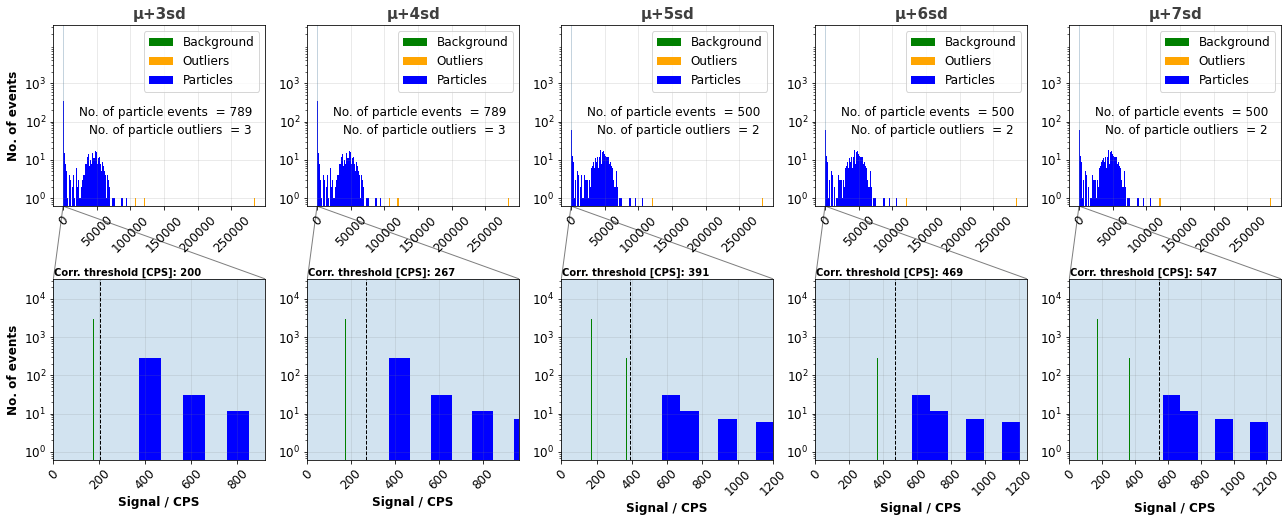

In [68]:
# Plot function
fig, ax = plt.subplots(figsize=(22,8))
rows = 2
columns = 5

#Is needed that you can have more than 9 subplots
grid = plt.GridSpec(rows, columns, wspace = .20, hspace = .4)
for i in range(rows*columns):
    exec (f"plt.subplot(grid{[i]})")
    plt.annotate('subplot 35_grid[' + str(i) + ']', xy = (0.5, 0.5), va = 'center', ha = 'center')

for p in sd_trials:
    q = p-sd_trials[0]    
    
    #Subplot definitions    
    ax_ = f'ax{q+1}'
    ax_ = plt.subplot(grid[q])

    plt.hist((dataframe_particle_ionic_mode_list[q][2]-np.mean(All_ionic_signal_list[q])), bins=99, alpha=1, color='green', label='Background')
    plt.hist(outliers_particles_data[q][1], color='orange',bins=99, alpha=1, label='Outliers')
    plt.hist(outliers_particles_data[q][2], bins=99, color='blue', alpha=1, label='Particles')
    plt.yscale('log')
    plt.annotate('No. of particle events  = %s' %event_number_list[q][1], xy=(0.12, 0.5), xycoords='axes fraction', fontsize=12)
    plt.annotate('No. of particle outliers  = %s' %event_number_list[q][3], xy=(0.17, 0.4), xycoords='axes fraction', fontsize=12)
    plt.title(f'µ+{p}sd', fontsize=15, fontweight='semibold', alpha=0.75)
    if q == 0:
        plt.ylabel('No. of events', fontsize=12, fontweight='semibold')
    plt.xscale('linear')
    plt.legend(loc=1, prop={'size':12})
    plt.grid(color= 'gray', alpha=0.2)
    plt.xticks(rotation = 45, fontsize=12)
    plt.yticks([1,10,100,1000],fontsize=12)
    
    ax__ = f'ax{q+6}'
    ax__ = plt.subplot(grid[q+5]) # Zoom µ + SD
    
    zoom_effect02(ax__, ax_)
    plt.hist((dataframe_particle_ionic_mode_list[q][2]-np.mean(All_ionic_signal_list[q])), bins=99, alpha=1, color='green', label='Background')
    plt.hist(outliers_particles_data[q][1], color='orange',bins=99, alpha=1, label='Outliers')
    plt.hist(outliers_particles_data[q][2], bins=999, color='blue', alpha=1, label='Particles')
    plt.xlabel('Signal / CPS', fontsize=12, fontweight='semibold')
    if q == 0:
        plt.ylabel('No. of events', fontsize=12, fontweight='semibold')
    plt.yscale('log')
    plt.xscale('linear')
    plt.xlim(int(0), (round_sig(int(PDT_list[q][1])))*20/(q+1*5)) # Zoom on x axis
    plt.grid(color= 'gray', alpha=0.2)
    plt.xticks(rotation = 45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.axvline(corr_background[q], color='black', lw=1, ls='--')
    plt.annotate('Corr. threshold [CPS]: %s' %int(corr_background[q]), xy=(0.004, 1.02), xycoords='axes fraction', fontsize=10, fontweight= 'semibold')

# Save figure
plt.savefig(new_name[0] + "_sums_zoom_gaussian" + ".png", bbox_inches='tight', dpi=300)

## Histograms (Poisson)

<ipython-input-69-d949d0910b58>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(grid[0])
<ipython-input-69-d949d0910b58>:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot(grid[1])


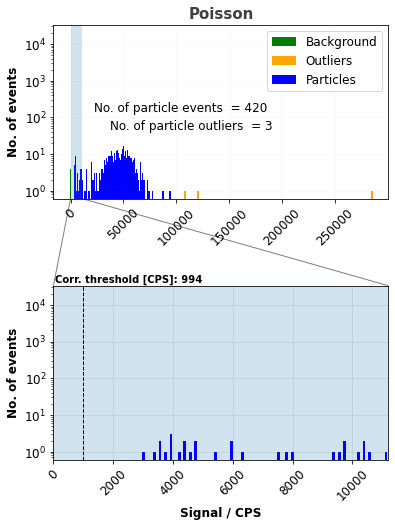

In [69]:
# Plot function
fig, ax = plt.subplots(figsize=(6,8))
rows = 2
columns = 1

#Is needed that you can have more than 9 subplots
grid = plt.GridSpec(rows, columns, wspace = .20, hspace = .5)
for i in range(rows*columns):
    exec (f"plt.subplot(grid{[i]})")

# Full Scale (Poisson)
ax1 = plt.subplot(grid[0])
plt.hist((dataframe_particle_ionic_mode_list_poisson[0][2]-poisson_limits[0][1]), bins=99, alpha=1, color='green', label='Background')
plt.hist(outliers_particles_data_poisson[0][1], color='orange',bins=100, alpha=1, label='Outliers')
plt.hist(outliers_particles_data_poisson[0][2], bins=100, color='blue', alpha=1, label='Particles')
plt.annotate('No. of particle events  = %s' %event_number_list_poisson[0][1], xy=(0.12, 0.5), xycoords='axes fraction', fontsize=12)
plt.annotate('No. of particle outliers  = %s' %event_number_list_poisson[0][3], xy=(0.17, 0.4), xycoords='axes fraction', fontsize=12)
plt.title('Poisson', fontsize=15, fontweight='semibold', alpha=0.75)
plt.ylabel('No. of events', fontsize=12, fontweight='semibold')
plt.yscale('log')
plt.xscale('linear')
plt.legend(loc=1, prop={'size':12})
plt.grid(color= 'gray', alpha=0.05)
plt.xticks(rotation = 45, fontsize=12)
plt.yticks(fontsize=12)
    
# Zoom (Poisson)
ax2 = plt.subplot(grid[1]) 
zoom_effect02(ax2, ax1)
plt.hist((dataframe_particle_ionic_mode_list_poisson[0][2]-poisson_limits[0][1]), bins=99, alpha=1, color='green', label='Background')
plt.hist(outliers_particles_data_poisson[0][1], color='orange',bins=99, alpha=1, label='Outliers')
plt.hist(outliers_particles_data_poisson[0][2], bins=999, color='blue', alpha=1, label='Particles')
plt.ylabel('No. of events', fontsize=12, fontweight='semibold')
plt.yscale('log')
plt.xscale('linear')
plt.xlim(int(0), (round_sig(int(poisson_limits[0][2])))*20/(1*5)) # Zoom on x axis
plt.grid(color= 'gray', alpha=0.2)
plt.xticks(rotation = 45, fontsize=12)
plt.yticks(fontsize=12)
plt.axvline(corr_background_poisson[0], color='black', lw=1, ls='--')
plt.annotate('Corr. threshold [CPS]: %s' %int(corr_background_poisson[0]), xy=(0.004, 1.02), xycoords='axes fraction', fontsize=10, fontweight= 'semibold',)    
plt.xlabel('Signal / CPS', fontsize=12, fontweight='semibold')

# Save figure
plt.savefig(new_name[0] + "_sums_zoom_poisson" + ".png", bbox_inches='tight', dpi=300)

# Nebulisation efficiency

In [70]:
###############   Gaussian   ###############
def nebulisation_efficiency(i):
    name = 'event_number_{}'.format(i)
    p = i-sd_trials[0]
    valid_events = len(outliers_particles_data[p][1] + outliers_particles_data[p][2])
    I_p = np.mean(outliers_particles_data[p][2])[0]
    te_pzm = (((4/3)*math.pi*((d_std/2)**3)*p_p*response*60)/((I_p-intercept)*dwell*flow_min*f_d*10**12))
    te_pzm_percent = te_pzm * 100
    te_pnm = ((valid_events)/(total_aquisition_time * flow))/((PNC_CRM)/DF) # Particle number method [absolute value]
    te_pnm_percent = te_pnm * 100
    return name,valid_events,te_pzm,te_pzm_percent, te_pnm,te_pnm_percent

nebulisation_efficiency_list = []

for i in sd_trials:
    nebulisation_efficiency_list.append(nebulisation_efficiency(i))

for p in range(len(nebulisation_efficiency_list)):
    print('Nebulisation efficiency (Particle Number Method) (Gaussian µ + {}SD) [%] = '.format(sd_trials[p]),
          round_sig(nebulisation_efficiency_list[p][5],3))
    print('Nebulisation efficiency (Particle Size Method) (Gaussian µ + {}SD) [%]   = '.format(sd_trials[p]),
          round_sig(nebulisation_efficiency_list[p][3],3))

###############   Poisson   ###############
def nebulisation_efficiency_poisson(i):
    name = 'event_number_{}'.format(i)
    p = i-sd_trials[0]
    valid_events_1_poisson = table1[list(table1.columns.values)[1]]>poisson_limits[p][2]
    valid_events_2_poisson = pd.DataFrame(valid_events_1_poisson)
    valid_events_poisson = valid_events_2_poisson[list(valid_events_2_poisson.columns.values)[0]].value_counts()[1]
    I_p_poisson = np.mean(outliers_particles_data_poisson[p][2])[0]
    te_pzm_poisson = (((4/3)*math.pi*((d_std/2)**3)*p_p*response*60)/((I_p_poisson-intercept)*dwell*flow_min*f_d*10**12))
    te_pzm_percent_poisson = te_pzm_poisson * 100
    te_pnm_poisson = ((valid_events_poisson)/(total_aquisition_time * flow))/((PNC_CRM)/DF) # Particle number method [absolute value]
    te_pnm_percent_poisson = te_pnm_poisson*100
    return name,valid_events_poisson,te_pzm_poisson,te_pzm_percent_poisson,te_pnm_poisson,te_pnm_percent_poisson

nebulisation_efficiency_list_poisson = []

for i in sd_trials[0:1]:
    nebulisation_efficiency_list_poisson.append(nebulisation_efficiency_poisson(i))

for p in range(1):
    print('Nebulisation efficiency Poisson (Particle Number Method) [%]            = '.format(sd_trials[p]),
          round_sig(nebulisation_efficiency_list_poisson[p][5],3))
    print('Nebulisation efficiency Poisson (Particle Size Method) [%]              = '.format(sd_trials[p]),
          round_sig(nebulisation_efficiency_list_poisson[p][3],3))

Nebulisation efficiency (Particle Number Method) (Gaussian µ + 3SD) [%] =  125.0
Nebulisation efficiency (Particle Size Method) (Gaussian µ + 3SD) [%]   =  108.0
Nebulisation efficiency (Particle Number Method) (Gaussian µ + 4SD) [%] =  125.0
Nebulisation efficiency (Particle Size Method) (Gaussian µ + 4SD) [%]   =  108.0
Nebulisation efficiency (Particle Number Method) (Gaussian µ + 5SD) [%] =  79.0
Nebulisation efficiency (Particle Size Method) (Gaussian µ + 5SD) [%]   =  72.1
Nebulisation efficiency (Particle Number Method) (Gaussian µ + 6SD) [%] =  79.0
Nebulisation efficiency (Particle Size Method) (Gaussian µ + 6SD) [%]   =  72.1
Nebulisation efficiency (Particle Number Method) (Gaussian µ + 7SD) [%] =  79.0
Nebulisation efficiency (Particle Size Method) (Gaussian µ + 7SD) [%]   =  72.1
Nebulisation efficiency Poisson (Particle Number Method) [%]            =  66.6
Nebulisation efficiency Poisson (Particle Size Method) [%]              =  62.1


## Mass calculation and standard deviations (Gaussian)

In [71]:
def masses(i):
    name = 'particle_mass_{}'.format(i)
    p = i-sd_trials[0]
    mass_1 = (((outliers_particles_data[p][2])-intercept)*dwell*flow*te*1000000)/response # in femtogram (fg)
    used_table = dataframe_particle_ionic_mode_list[p][1].iloc[:,:]
    mass = ((used_table-intercept)*dwell*flow*te*1000000)/response # in femtogram (fg)
    
    mean_mass = np.mean(mass)
    median_mass = np.median(mass)
    mode_mass = stats.mode(mass[0])
    sd = np.std(mass)
    return name,mass,mean_mass,median_mass,mode_mass,sd

masses_list = []

for i in sd_trials:
    masses_list.append(masses(i))
    
##Particle masses => masses_list[p][1]
##Mean mass => masses_list[p][2]
##Median mass => masses_list[p][3]
##Mode mass => masses_list[p][4]
##Sd mass => masses_list[p][5]''

## Mass calculation and standard deviations (Poisson)

In [72]:
def masses_poisson(i):
    name = 'particle_mass_poisson{}'.format(i)
    p = i-sd_trials[0]
    mass_poisson = (((outliers_particles_data_poisson[p][2])-intercept)*dwell*flow*te*1000000)/(response) # in femtogram (fg)
    mean_mass_poisson = np.mean(mass_poisson)
    median_mass_poisson = np.median(mass_poisson)
    mode_mass_poisson = stats.mode(mass_poisson[0])
    sd_poisson = np.std(mass_poisson)
    return name,mass_poisson,mean_mass_poisson,median_mass_poisson,mode_mass_poisson,sd_poisson

masses_list_poisson = []

for i in sd_trials[0:1]:
    masses_list_poisson.append(masses_poisson(i))

##Particle sizes => masses_list_poisson[p][1]
##Mean mass => masses_list_poisson[p][2]
##Median mass => masses_list_poisson[p][3]
##Mode mass => masses_list_poisson[p][4]
##Sd mass => masses_list_poisson[p][5]

## Calculation of mass and size detection limit (Gaussian)

In [73]:
# Same way as spcal
def LOD(i):
    name = 'LOD_mass_size_{}'.format(i)
    p = i-sd_trials[0]
    m_LOD = (corr_background[p]-intercept) * (response)**-1 * dwell * flow * te *10**6 # Important instead of the original PDT, here we took "corr_background[p]" the PDT-mean baseline (see peak integration)
    size_LOD = ((6 * m_LOD * f_d) / (math.pi * 10**15 * p_p))**(1/3) * 10**7
    if isinstance(size_LOD,complex): size_LOD = math.nan
    return name, m_LOD, size_LOD

LOD_list = []

for i in sd_trials:
    LOD_list.append(LOD(i))

for p in range(len(LOD_list)):
    print('LOD mass (µ + {} SD) [fg/particle] = '.format(sd_trials[p]), LOD_list[p][1])
    print('LOD diameter (µ + {} SD) [nm] = '.format(sd_trials[p]), LOD_list[p][2])
    
## Mass LOD => LOD_list[p][1]
## Diameter LOD => LOD_list[p][2]

LOD mass (µ + 3 SD) [fg/particle] =  0.02836538543407872
LOD diameter (µ + 3 SD) [nm] =  14.101359401777973
LOD mass (µ + 4 SD) [fg/particle] =  0.028841604582806737
LOD diameter (µ + 4 SD) [nm] =  14.179836545908461
LOD mass (µ + 5 SD) [fg/particle] =  0.02972469429961626
LOD diameter (µ + 5 SD) [nm] =  14.323106379329824
LOD mass (µ + 6 SD) [fg/particle] =  0.030282184380911643
LOD diameter (µ + 6 SD) [nm] =  14.41209617775677
LOD mass (µ + 7 SD) [fg/particle] =  0.03084038736512427
LOD diameter (µ + 7 SD) [nm] =  14.500112106654237


## Calculation of mass and size detection limit (Poisson)

In [74]:
def LOD_poisson(i):
    name = 'LOD_mass_size_{}'.format(i)
    p = i-sd_trials[0]
    m_LOD = (corr_background_poisson[p]-intercept) * (response)**-1 * dwell * flow * te *10**6 # Important instead of the original PDT, here we took "corr_background_poisson[p]" the PDT-mean baseline (see peak integration)
    size_LOD = ((6 * m_LOD * f_d) / (math.pi * 10**15 * p_p))**(1/3) * 10**7
    if isinstance(size_LOD,complex): size_LOD = math.nan
    return name, m_LOD, size_LOD

LOD_list_poisson = []

for i in sd_trials[0:1]:
    LOD_list_poisson.append(LOD_poisson(i))

for p in range(1):
    print('LOD mass [fg/event] = '.format(sd_trials[p]), LOD_list_poisson[p][1])
    print('LOD diameter [nm]      = '.format(sd_trials[p]), LOD_list_poisson[p][2])
    
## Mass LOD => LOD_list_poisson[p][1]
## Diameter LOD => LOD_list_poisson[p][2]

LOD mass [fg/event] =  0.034023747983981695
LOD diameter [nm]      =  14.982770808349931


## Comparison of mass and size Background equivalent diameter via MassHunter from Agilent (Poisson)

In [75]:
def LOD_MassHunter(i):
    name = 'LOD_mass_size_MassHunter{}'.format(i)
    p = i-sd_trials[0]
    mean_particle = np.mean(outliers_particles_data[p][2])
    m_bkgnd_unknown = (np.mean(dataframe_particle_ionic_mode_list_poisson[p][2])-intercept) * (response)**-1 * dwell * flow * te *10**6 * f_d
    d_bkgnd = ((6 * m_bkgnd_unknown) / (math.pi * 10**15 * p_p))**(1/3) * 10**7
    return name, mean_particle, m_bkgnd_unknown, d_bkgnd

MassHunter_sizes_list = []

for i in sd_trials[0:1]:
    MassHunter_sizes_list.append(LOD_MassHunter(i))

for p in range(1):
    print('LOD mass [MassHunter] [fg/event] = '.format(sd_trials[p]), MassHunter_sizes_list[p][2][0])
    print('LOD diameter [MassHunter]  [nm] = '.format(sd_trials[p]), MassHunter_sizes_list[p][3][0])
    
## Mean_particle => MassHunter_sizes_list[p][1]
## Sample mass => MassHunter_sizes_list[p][2]
## Sample diameter => MassHunter_sizes_list[p][3]

LOD mass [MassHunter] [fg/event] =  0.027168653074914773
LOD diameter [MassHunter]  [nm] =  13.900191642447187


## Peak fitting (Gaussian)

In [76]:
def gaussians_1(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) 

def gaussians_2(x, a_0, a_1, x_0, x_1, s_0, s_1):
    n = 2
    a_s = [a_0, a_1]
    x0_s = [x_0, x_1]
    sigma_s = [s_0, s_1]
    return sum([gaussians_1(x,a_s[i],x0_s[i],sigma_s[i]) for i in range(n)])

def gaussians_3(x, a_0, a_1, a_2, x_0, x_1, x_2, s_0, s_1, s_2):
    n = 3
    a_s = [a_0, a_1, a_2]
    x0_s = [x_0, x_1, x_2]
    sigma_s = [s_0, s_1, s_2]
    return sum([gaussians_1(x,a_s[i],x0_s[i],sigma_s[i]) for i in range(n)])

def gaussians_4(x, a_0, a_1, a_2, a_3, x_0, x_1, x_2, x_3, s_0, s_1, s_2, s_3):
    n = 4
    a_s = [a_0, a_1, a_2, a_3]
    x0_s = [x_0, x_1, x_2, x_3]
    sigma_s = [s_0, s_1, s_2, s_3]
    return sum([gaussians_1(x,a_s[i],x0_s[i],sigma_s[i]) for i in range(n)])

def fit_n_gaussians(n,x_data,y_data, bounds = (0, 400)):
    if n == 1:
        popt, pcov = curve_fit(gaussians_1, x_data, y_data, bounds=bounds)
        #print(*[gaussians_1(popt[1],*popt)])
        plt.plot(h[1][:-1],gaussians_1(h[1][:-1], *popt))
        
    if n == 2:
        popt, pcov = curve_fit(gaussians_2, x_data, y_data, bounds=bounds)
        #print(*[gaussians_2(popt[i],*popt) for i in range(n,2*n)])
        plt.plot(h[1][:-1],gaussians_2(h[1][:-1], *popt))
        
    if n == 3:
        popt, pcov = curve_fit(gaussians_3, x_data, y_data, bounds=bounds)
        #print(*[gaussians_3(popt[i],*popt) for i in range(n,2*n)])
        plt.plot(h[1][:-1],gaussians_3(h[1][:-1], *popt))
        
    if n == 4:
        popt, pcov = curve_fit(gaussians_4, x_data, y_data, bounds=bounds)
        #print(*[gaussians_4(popt[i],*popt) for i in range(n,2*n)])
        plt.plot(h[1][:-1],gaussians_4(h[1][:-1], *popt))
                
    #print(f"Gaussians found at x_0={popt[n:2*n]}, amplitudes={popt[:n]} and sigma={popt[2*n:]}")
    return popt,pcov

def save_data(p, n, popt, x, y):
    peaks_of_p = []
    info_data = []
    
    for _ in range(n):
        lower = popt[n+_] - 2*popt[2*n+_]
        upper = popt[n+_] + 2*popt[2*n+_]
        
        peak_group = []
        events_group = []
     
        #for i in x:
            #if i >= lower and i <= upper:
                #peak_group.append(i)
                #index = np.where(x == i)
                #events_group.append(y[index])
                
        #if len(peak_group) < 1:
            #peak_group = [0.0]
            #events_group = [0.0]
        #peaks_of_p.append(peak_group)

        for i in x:
            if i >= lower and i <= upper:
                index = np.where(x == i)
                events_group.append(y[index])
                peak_group.append(','.join(map(str,(np.repeat(round(i,4),int(y[index]))))))
        
        peak_group = str(','.join(peak_group).split(','))

                #peak_group.append((i,int(y[index])))
        if len(peak_group) < 1:
            peak_group = "['0.0']"
            events_group = [0.0]
        peaks_of_p.append(peak_group)

        n_events = int(np.sum(events_group))
        PNC_of_p = PNC_calculator(p,n_events,0)
        
        mean_2SD = f"peak {_} of {p}SD: {round(popt[n+_],3)} +/- {round(popt[2*n+_],3)} fg/nm for {n_events} events and {PNC_of_p[2]} particles/mL"
        info_data.append(mean_2SD)    

    if n < 4:
        for _ in range(4-n):
            extra_peaks = "['0.0']"
            extra_data = "-"
            peaks_of_p.extend([extra_peaks])
            info_data.extend(extra_data)
            
    return peaks_of_p,info_data


## Mass histograms (Gaussian)

### !!! Adapt  line 18 (n = number of expected peaks);
### !!! line 19 "(max(h[1]))+"NUMBER"*(max(h[1]))(max(h[1]))+100*(max(h[1]))";
### !!! line 21 "gaussians_"n"" 

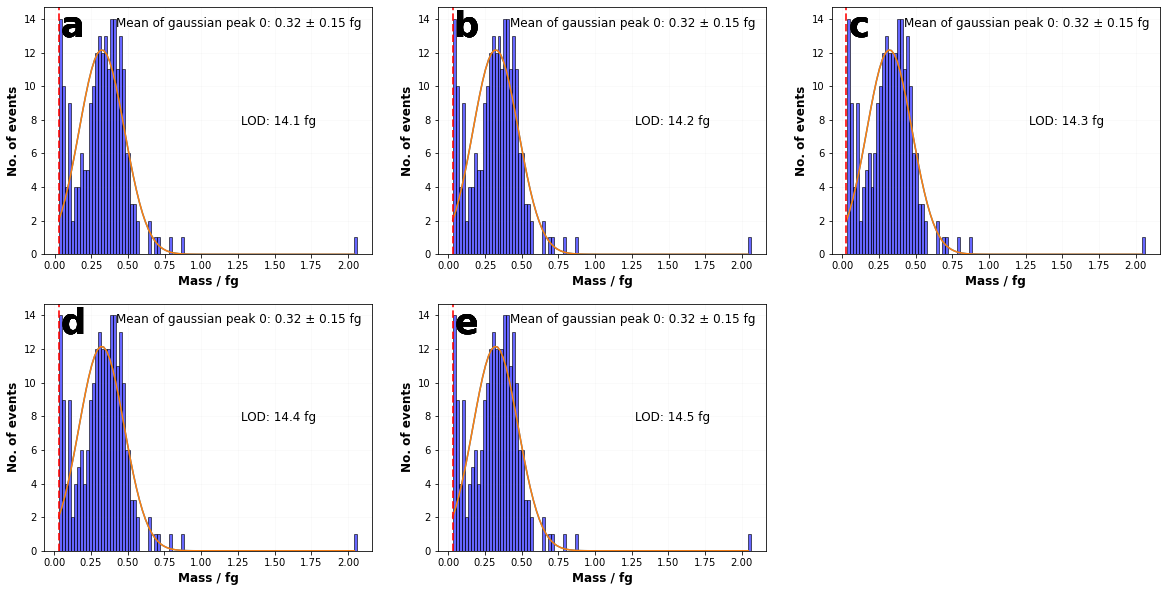

In [77]:
# Plot subplots for Nanoparticle Data
fig, ax = plt.subplots(figsize=(20,10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

masses_peaks_gaussian = []
info_masses_peaks_gaussian = []

for p in sd_trials:
    q = p-sd_trials[0]
    plot = 231+q
    plt.subplot(plot)
    
    df_masses_SD = masses_list[q][1].value_counts().to_frame(name= 'Frequency')
    df_masses_SD = df_masses_SD.reset_index()
    df_masses_SD_final = df_masses_SD.sort_values(df_masses_SD.columns[0])[0]
    
    h = plt.hist(df_masses_SD_final, bins=100, color='blue', edgecolor='k',alpha=0.6)
    n = 1
    max_x = (max(h[1]))+90*(max(h[1]))
    popt, pcov = fit_n_gaussians(n, h[1][:-1], h[0], bounds = (0,max_x))
    plt.plot(h[1][:-1],gaussians_1(h[1][:-1], *popt))  #change gaussian_n accordingly
    
    storage = save_data(p, n, popt, h[1][:-1], h[0])
    masses_peaks_gaussian.append(storage[0])
    info_masses_peaks_gaussian.append(storage[1])
    
    for _ in range(n):
        plt.annotate('Mean of gaussian peak {}: %s'.format(_) %round(popt[n+_],2) + ' \u00B1 %s'%round(popt[2*n+_],2) + ' fg', xy=(0.22, 0.92-(_*0.1)),
                     xycoords='axes fraction', fontsize=12)
    plt.annotate('LOD: %s' %round_sig(LOD_list[q][2],3) + ' fg', xy=(0.6, 0.525), xycoords='axes fraction', fontsize=12)
    #plt.legend(loc=[1.5,1.10], prop={'size':15})
    plt.grid(color= 'gray', alpha=0.05)
    plt.axvline(LOD_list[q][1], color='red', lw=2, ls='--', alpha=0.8)
    plt.xlabel('Mass / fg', fontsize=12, fontweight='semibold')
    plt.ylabel('No. of events', fontsize=12, fontweight='semibold')
    letter = ['a','b','c','d','e']
    for x in letter:
        plt.annotate(letter[q], xy=(0.05, 0.88), xycoords='axes fraction',fontweight= 'semibold',  fontsize=35)

# Save figure
plt.savefig(new_name[0] + "_mass_histograms_gaussian" + ".png", bbox_inches='tight', dpi=300)

## Mass histograms (Poisson)

### !!! Adapt  line 18 (n = number of expected peaks);
### !!! line 19 "(max(h[1]))+"NUMBER"*(max(h[1]))(max(h[1]))+100*(max(h[1]))";
### !!! line 21 "gaussians_"n"" 

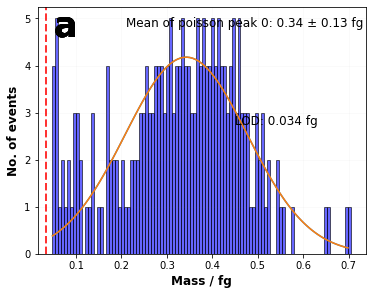

In [78]:
# Plot subplots for Nanoparticle Data
fig, ax = plt.subplots(figsize=(20,10))
fig.subplots_adjust(hspace=0.20, wspace=0.20)

masses_peaks_poisson = []
info_masses_peaks_poisson = []

for p in sd_trials[0:1]:
    q = p-sd_trials[0]
    plot = 231+q
    plt.subplot(plot)
    
    df_masses_SD = masses_list_poisson[q][1].value_counts().to_frame(name= 'Frequency')
    df_masses_SD = df_masses_SD.reset_index()
    df_masses_SD_final = df_masses_SD.sort_values(df_masses_SD.columns[0])[0]

    h = plt.hist(df_masses_SD_final, bins=100, color='blue', edgecolor='k',alpha=0.6)
    n = 1
    max_x = (max(h[1]))+95*(max(h[1]))
    popt, pcov = fit_n_gaussians(n, h[1][:-1], h[0], bounds = (0,max_x))
    plt.plot(h[1][:-1],gaussians_1(h[1][:-1], *popt))  #change gaussian_n accordingly

    storage = save_data(p, n, popt, h[1][:-1], h[0])
    masses_peaks_poisson.append(storage[0])
    info_masses_peaks_poisson.append(storage[1])
    for _ in range(n):
        plt.annotate('Mean of poisson peak {}: %s'.format(_) %round(popt[n+_],2) + ' \u00B1 %s'%round(popt[2*n+_],2) + ' fg', xy=(0.27, 0.92-(_*0.1)), xycoords='axes fraction', fontsize=12)  
    plt.annotate('LOD: %s' %round_sig(LOD_list_poisson[q][1],3) + ' fg', xy=(0.6, 0.525), xycoords='axes fraction', fontsize=12)
    #plt.legend(loc=[1.5,1.10], prop={'size':15})
    plt.grid(color= 'gray', alpha=0.05)
    plt.axvline(LOD_list_poisson[q][1], color='red', lw=2, ls='--', alpha=0.8)
    plt.xlabel('Mass / fg', fontsize=12, fontweight='semibold')
    plt.ylabel('No. of events', fontsize=12, fontweight='semibold')
    letter = ['a','b','c','d','e']
    for x in letter:
        plt.annotate(letter[q], xy=(0.05, 0.88), xycoords='axes fraction',fontweight= 'semibold',  fontsize=35)

plt.savefig(new_name[0] + "_mass_histograms_gaussian_poisson" + ".png", bbox_inches='tight', dpi=300)

## Size calculations (Gaussian)

In [79]:
def sizes(i):
    name = 'particle_size{}'.format(i)
    p = i-sd_trials[0]
    diameter = ((((6 * masses_list[p][1] * f_d)/(math.pi * 10**15 * p_p)))**(1/3)) * 10**7 # in nm
    mean_diameter = np.mean(diameter)
    median_diameter = np.median(diameter)
    mode_diameter = stats.mode(diameter[0])
    sd = np.std(diameter)
    return name, diameter, mean_diameter, median_diameter, mode_diameter, sd
sizes_list = []

for i in sd_trials:
    sizes_list.append(sizes(i))

##Particle diameters => sizes_list[p][1]
##Mean diameter => sizes_list[p][2]
##Median diameter => sizes_list[p][3]
##Mode diameter => sizes_list[p][4]
##Sd diameter => sizes_list[p][5]

## Size calculations (Poisson)

In [80]:
def sizes_poisson(i):
    name = 'particle_size_poisson{}'.format(i)
    p = i-sd_trials[0]
    diameter = ((((6 * masses_list_poisson[p][1] * f_d)/(math.pi * 10**15 * p_p)))**(1/3)) * 10**7 # in nm
    mean_diameter = np.mean(diameter)
    median_diameter = np.median(diameter)
    mode_diameter = stats.mode(diameter[0])
    sd = np.std(diameter)
    return name, diameter, mean_diameter, median_diameter, mode_diameter, sd
sizes_list_poisson = []

for i in sd_trials[0:1]:
    sizes_list_poisson.append(sizes_poisson(i))

##Particle diameters => sizes_list_poisson[p][1]
##Mean diameter => sizes_list_poisson[p][2]
##Median diameter => sizes_list_poisson[p][3]
##Mode diameter => sizes_list_poisson[p][4]
##Sd diameter => sizes_list_poisson[p][5]

## Size histograms (Gaussian)

### !!! Adapt  line 18 (n = number of expected peaks);
### !!! line 19 "(max(h[1]))+"NUMBER"*(max(h[1]))(max(h[1]))+100*(max(h[1]))";
### !!! line 21 "gaussians_"n"" 

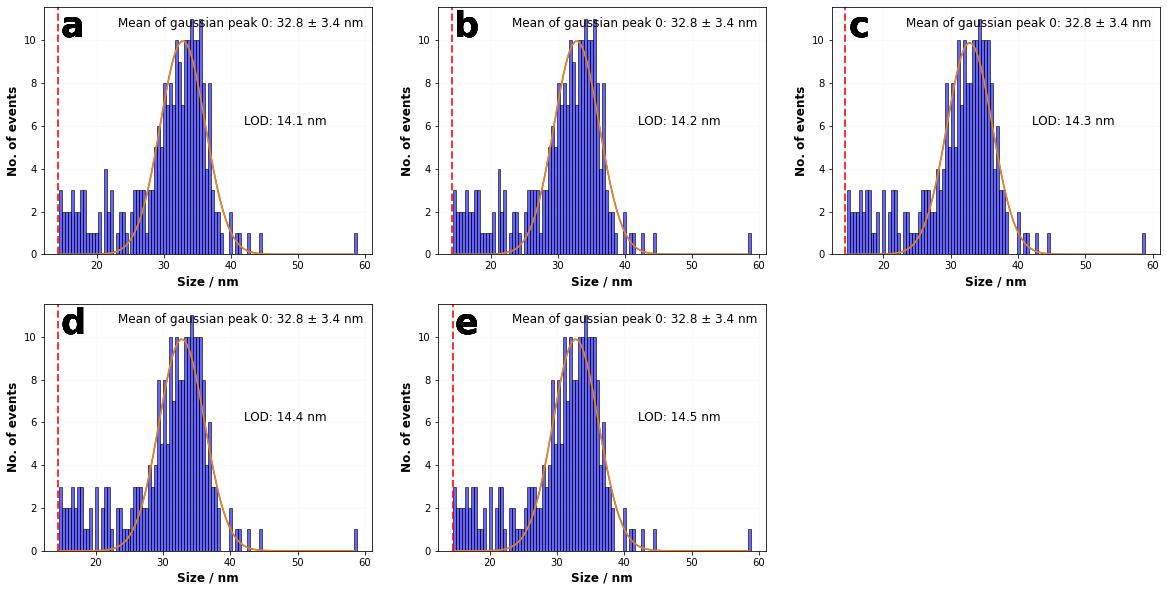

In [81]:
# Plot subplots for Nanoparticle Data
fig, ax = plt.subplots(figsize=(20,10))
fig.subplots_adjust(hspace=0.2, wspace=0.20)

sizes_peaks_gaussian = []
info_sizes_peaks_gaussian = []

for p in sd_trials:
    q = p-sd_trials[0]
    plot = 231+q
    plt.subplot(plot)
    
    df_sizes_SD = sizes_list[q][1].value_counts().to_frame(name= 'Frequency')
    df_sizes_SD = df_sizes_SD.reset_index()
    df_sizes_SD_final = df_sizes_SD.sort_values(df_sizes_SD.columns[0])[0]
    
    h = plt.hist(df_sizes_SD_final, bins=100, color='blue', edgecolor='k',alpha=0.6)
    n = 1
    max_x = int(max(h[1]))+0.2*int(max(h[1]))
    popt, pcov = fit_n_gaussians(n, h[1][:-1], h[0], bounds = (0,max_x))
    plt.plot(h[1][:-1],gaussians_1(h[1][:-1], *popt))  #change gaussian_n accordingly

    storage = save_data(p, n, popt, h[1][:-1], h[0])
    sizes_peaks_gaussian.append(storage[0])
    info_sizes_peaks_gaussian.append(storage[1])

    for _ in range(n):
        plt.annotate('Mean of gaussian peak {}: %s'.format(_) %round(popt[n+_],1) + ' \u00B1 %s'%round(popt[2*n+_],1) + ' nm', xy=(0.225, 0.92-(_*0.1)),
                     xycoords='axes fraction', fontsize=12)    
    plt.annotate('LOD: %s' %round_sig(LOD_list[q][2],3) + ' nm', xy=(0.61, 0.525), xycoords='axes fraction', fontsize=12)
    #plt.legend(loc=[1.5,1.10], prop={'size':15})
    plt.grid(color= 'gray', alpha=0.05)
    plt.axvline(LOD_list[q][2], color='red', lw=2, ls='--', alpha=0.8)
    plt.xlabel('Size / nm', fontsize=12, fontweight='semibold')
    plt.ylabel('No. of events', fontsize=12, fontweight='semibold')
    letter = ['a','b','c','d','e']
    for x in letter:
        plt.annotate(letter[q], xy=(0.05, 0.88), xycoords='axes fraction',fontweight= 'semibold',  fontsize=35)
        
plt.savefig(new_name[0] + "_size_histograms_gaussian" + ".png", bbox_inches='tight', dpi=300)

## Size histograms (Poisson)

### !!! Adapt  line 18 (n = number of expected peaks);
### !!! line 19 "(max(h[1]))+"NUMBER"*(max(h[1]))(max(h[1]))+100*(max(h[1]))";
### !!! line 21 "gaussians_"n"" 

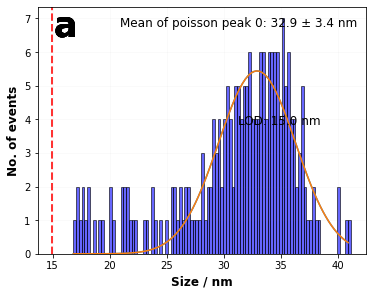

In [82]:
# Plot subplots for Nanoparticle Data
fig, ax = plt.subplots(figsize=(20,10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

sizes_peaks_poisson = []
info_sizes_peaks_poisson = []

for p in sd_trials[0:1]:
    q = p-sd_trials[0]
    plot = 231+q
    plt.subplot(plot)
    
    df_sizes_SD = sizes_list_poisson[q][1].value_counts().to_frame(name= 'Frequency')
    df_sizes_SD = df_sizes_SD.reset_index()
    df_sizes_SD_final = df_sizes_SD.sort_values(df_sizes_SD.columns[0])[0]
    
    h = plt.hist(df_sizes_SD_final, bins=100, color='blue', edgecolor='k',alpha=0.6)
    n = 1
    max_x = int(max(h[1]))+50*int(max(h[1]))
    popt, pcov = fit_n_gaussians(n, h[1][:-1], h[0], bounds = (0,max_x))
    plt.plot(h[1][:-1],gaussians_1(h[1][:-1], *popt))  #change gaussian_n accordingly

    storage = save_data(p, n, popt, h[1][:-1], h[0])
    sizes_peaks_poisson.append(storage[0])
    info_sizes_peaks_poisson.append(storage[1])
    
    for _ in range(n):
        plt.annotate('Mean of poisson peak {}: %s'.format(_) %round(popt[n+_],1) + ' \u00B1 %s'%round(popt[2*n+_],1) + ' nm', xy=(0.25, 0.92-(_*0.1)), xycoords='axes fraction', fontsize=12)
    plt.annotate('LOD: %s' %round_sig(LOD_list_poisson[q][2],3) + ' nm', xy=(0.61, 0.525), xycoords='axes fraction', fontsize=12)
    #plt.legend(loc=[1.5,1.10], prop={'size':15})
    plt.grid(color= 'gray', alpha=0.05)
    plt.axvline(LOD_list_poisson[q][2], color='red', lw=2, ls='--', alpha=0.8)    
    plt.xlabel('Size / nm', fontsize=12, fontweight='semibold')
    plt.ylabel('No. of events', fontsize=12, fontweight='semibold')
    letter = ['a','b','c','d','e']
    for x in letter:
        plt.annotate(letter[q], xy=(0.05, 0.88), xycoords='axes fraction',fontweight= 'semibold',  fontsize=35)

plt.savefig(new_name[0] + "_size_histograms_gaussian_poisson" + ".png", bbox_inches='tight', dpi=300)

# Particle mass concentrations

## Gaussian

In [83]:
def mass_conc(i):
    p = i-sd_trials[0]
    name = 'mass_conc. µ+{}'.format(i)+'SD'
    mass_conc_sum = ((np.sum(masses_list[p][1])[0])*(10**3)/(flow*te*total_aquisition_time))*DF*10**-12 # masses in masses_list in fg
    mass_conc_mean = (masses_list[p][2] * event_number_list[p][4] * 10**-3)*10**-6 # DF is already in "event_number_list"
    return name, mass_conc_sum, mass_conc_mean
mass_conc_list = []
for i in sd_trials:
    mass_conc_list.append(mass_conc(i))

for p in range(len(mass_conc_list)):
    print('Mass conc. [via sum] (Gaussian µ + {}SD) [mg/L]  = '.format(sd_trials[p]), mass_conc_list[p][1])
    print('Mass conc. [via mean] (Gaussian µ + {}SD) [mg/L] = '.format(sd_trials[p]), mass_conc_list[p][2][0])
    
##Mass concentration (via sum) => mass_conc_list[p][1]
##Mass concentration (via mean) => mass_conc_list[p][2]

Mass conc. [via sum] (Gaussian µ + 3SD) [mg/L]  =  61.31938210084389
Mass conc. [via mean] (Gaussian µ + 3SD) [mg/L] =  61.08711171409779
Mass conc. [via sum] (Gaussian µ + 4SD) [mg/L]  =  61.31938210084389
Mass conc. [via mean] (Gaussian µ + 4SD) [mg/L] =  61.08711171409779
Mass conc. [via sum] (Gaussian µ + 5SD) [mg/L]  =  57.93552025841306
Mass conc. [via mean] (Gaussian µ + 5SD) [mg/L] =  57.70470145260257
Mass conc. [via sum] (Gaussian µ + 6SD) [mg/L]  =  57.93552025841306
Mass conc. [via mean] (Gaussian µ + 6SD) [mg/L] =  57.70470145260257
Mass conc. [via sum] (Gaussian µ + 7SD) [mg/L]  =  57.93552025841306
Mass conc. [via mean] (Gaussian µ + 7SD) [mg/L] =  57.70470145260257


## Poisson

In [84]:
def mass_conc_poisson(i):
    p = i-sd_trials[0]
    name_poisson = 'mass_conc. µ+{}'.format(i)+'SD'
    mass_conc_sum_poisson = ((np.sum(masses_list_poisson[p][1])[0])*(10**3)/(flow*te*total_aquisition_time))*DF*10**-12 # masses in masses_list in fg
    mass_conc_mean_poisson = (masses_list_poisson[p][2] * event_number_list_poisson[p][4] * 10**-3)*10**-6 # DF is already in "event_number_list"
    return name_poisson, mass_conc_sum_poisson, mass_conc_mean_poisson
mass_conc_list_poisson = []
for i in sd_trials[0:1]:
    mass_conc_list_poisson.append(mass_conc_poisson(i))

for p in range(1):
    print('Mass conc. [via sum] (Poisson) [mg/L]  = '.format(sd_trials[p]), mass_conc_list_poisson[p][1])
    print('Mass conc. [via mean] (Poisson) [mg/L] = '.format(sd_trials[p]), mass_conc_list_poisson[p][2][0])
    
##Mass concentration (via sum) => mass_conc_list[p][1]
##Mass concentration (via mean) => mass_conc_list[p][2]

Mass conc. [via sum] (Poisson) [mg/L]  =  55.38011676883293
Mass conc. [via mean] (Poisson) [mg/L] =  55.38011676883294


## Save Mean, median, mode and SD for masses and sizes

### Gaussian

In [85]:
##Particle diameters => sizes_list[p][1]
##Mean diameter => sizes_list[p][2]
##Median diameter => sizes_list[p][3]
##Mode diameter => sizes_list[p][4]
##Sd diameter => sizes_list[p][5]

#Gaussian 'masses_list_export_(µ+{}SD)[fg]'.format(p)
def masses_sizes_summary_excel(i):
    name = 'masses_summary{}'.format(i)
    p = i-sd_trials[0]
    masses_list_excel = [round_sig(np.mean(masses_list[p][1][0]),3), round_sig(np.median(masses_list[p][1][0]),3), round_sig(np.std(masses_list[p][1][0]),3),
                         stats.mode(masses_list[p][1][0].round(decimals=2))]
    sizes_list_excel=[round_sig(np.mean(sizes_list[p][1][0]),3), round_sig(np.median(sizes_list[p][1][0]),3), round_sig(np.std(sizes_list[p][1][0]),3),
                     stats.mode(sizes_list[p][1][0].round(decimals=2))]
    return name, masses_list_excel, sizes_list_excel

masses_sizes_list_excel = []

for i in sd_trials:
    masses_sizes_list_excel.append(masses_sizes_summary_excel(i))
# Get masses from masses_sizes_list_excel[p][1]
# Get sizes from masses_sizes_list_excel[p][2]

### Poisson

In [86]:
##Particle diameters => sizes_list[p][1]
##Mean diameter => sizes_list[p][2]
##Median diameter => sizes_list[p][3]
##Mode diameter => sizes_list[p][4]
##Sd diameter => sizes_list[p][5]

#Gaussian 'masses_list_export_(µ+{}SD)[fg]'.format(p)
def masses_sizes_summary_excel_poisson(i):
    name = 'masses_summary{}'.format(i)
    p = i-sd_trials[0]
    masses_list_excel_poisson = [round_sig(np.mean(masses_list_poisson[p][1][0]),3), round_sig(np.median(masses_list_poisson[p][1][0]),3), round_sig(np.std(masses_list_poisson[p][1][0]),3),
                         stats.mode(masses_list_poisson[p][1][0].round(decimals=2))]
    sizes_list_excel_poisson=[round_sig(np.mean(sizes_list_poisson[p][1][0]),3), round_sig(np.median(sizes_list_poisson[p][1][0]),3), round_sig(np.std(sizes_list_poisson[p][1][0]),3),
                     stats.mode(sizes_list_poisson[p][1][0].round(decimals=2))]
    return name, masses_list_excel_poisson, sizes_list_excel_poisson

masses_sizes_list_excel_poisson = []

for i in sd_trials[0:1]:
    masses_sizes_list_excel_poisson.append(masses_sizes_summary_excel_poisson(i))
# Get masses from masses_sizes_list_excel_poisson[p][1]
# Get sizes from masses_sizes_list_excel_poisson[p][2]

## Save data into Excel file

In [87]:
# Change figure size
def calculate_scale(file_path, bound_size):
    # check the image size without loading it into memory
    im = Image.open(file_path)
    original_width, original_height = im.size

    # calculate the resize factor, keeping original aspect and staying within boundary
    bound_width, bound_height = bound_size
    ratios = (float(bound_width) / original_width, float(bound_height) / original_height)
    return min(ratios)

name = new_name[0]+'_output.xlsx'
# define excel write function
writer = pd.ExcelWriter(name, engine='xlsxwriter')

####################### Baseline correction #######################
df=pd.DataFrame([ionic_mode_est], columns=['Ionic mode estimation (CPS)'])
df.to_excel(writer, sheet_name="Baseline correction", index=False)
worksheet = writer.sheets['Baseline correction']
worksheet.set_tab_color('magenta')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Baseline correction'].set_column(col_idx, col_idx, column_length)
resize_scale = calculate_scale(new_name[0] + "_baseline_correction" + ".png", (1800,1800))
worksheet.insert_image('A3', new_name[0] + "_baseline_correction" + ".png", {'x_scale': resize_scale, 'y_scale': resize_scale}) # Insert image

####################### PDT (Gaussian) #######################
A = pd.DataFrame([PDT3])
B = pd.DataFrame([PDT4])
C = pd.DataFrame([PDT5])
D = pd.DataFrame([PDT6])
E = pd.DataFrame([PDT7])
columns = [new_name[0][:-2]+'_µ+3SD_spICP-MS_(CPS)',new_name[0][:-2]+'_µ+4SD_spICP-MS_(CPS)',new_name[0][:-2]+'_µ+5SD_spICP-MS_(CPS)',new_name[0][:-2]+'_µ+6SD_spICP-MS_(CPS)',new_name[0][:-2]+'_µ+7SD_spICP-MS_(CPS)']
df = pd.concat([A,B,C,D,E], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="PDT_Gaussian", index=False)
worksheet = writer.sheets['PDT_Gaussian']
worksheet.set_tab_color('green')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['PDT_Gaussian'].set_column(col_idx, col_idx, column_length)
resize_scale = calculate_scale(new_name[0] + "_time_zoom_gaussian" + ".png", (2800,2800))
worksheet.insert_image('A4', new_name[0] + "_time_zoom_gaussian" + ".png", {'x_scale': resize_scale, 'y_scale': resize_scale}) # Insert image

####################### LC & PDT (Poisson) #######################
Index = pd.DataFrame(['Critical value (LC)', 'Particle Detection Threshold (PDT)'])
A = pd.DataFrame([poisson_limits[0][1], poisson_limits[0][2]])
columns = ['Parameter', new_name[0][:-2]+'_Poisson_spICP-MS_(CPS)']
df = pd.concat([Index,A], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="PDT_LC_Poisson", index=False)
worksheet = writer.sheets['PDT_LC_Poisson']
worksheet.set_tab_color('green') # Set Tab Colour
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['PDT_LC_Poisson'].set_column(col_idx, col_idx, column_length)
resize_scale = calculate_scale(new_name[0] + "_time_zoom_poisson" + ".png", (1200,1200))
worksheet.insert_image('A4', new_name[0] + "_time_zoom_poisson" + ".png", {'x_scale': resize_scale, 'y_scale': resize_scale}) # Insert image

####################### Transport efficiency #######################
Index = pd.DataFrame(['TE (Particle Number/Frequency Method)','TE (Particle Size Method)'])
A = pd.DataFrame([nebulisation_efficiency_list[0][5], nebulisation_efficiency_list[0][3]])
B = pd.DataFrame([nebulisation_efficiency_list[1][5], nebulisation_efficiency_list[1][3]])
C = pd.DataFrame([nebulisation_efficiency_list[2][5], nebulisation_efficiency_list[2][3]])
D = pd.DataFrame([nebulisation_efficiency_list[3][5], nebulisation_efficiency_list[3][3]])
E = pd.DataFrame([nebulisation_efficiency_list[4][5], nebulisation_efficiency_list[4][3]])
columns = ['Parameter',
           new_name[0][:-2]+'_µ+3SD_spICP-MS_(%)',
           new_name[0][:-2]+'_µ+4SD_spICP-MS_(%)',
           new_name[0][:-2]+'_µ+5SD_spICP-MS_(%)',
           new_name[0][:-2]+'_µ+6SD_spICP-MS_(%)',
           new_name[0][:-2]+'_µ+7SD_spICP-MS_(%)']
df = pd.concat([Index,A,B,C,D,E], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="TE", index=False)
worksheet = writer.sheets['TE']
worksheet.set_tab_color('white') # Set Tab Colour
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['TE'].set_column(col_idx, col_idx, column_length)

####################### Particle raw signals (Gaussian) #######################
A = outliers_particles_data[0][2].copy().sort_values(A.columns[0]).reset_index(drop=True)
B = outliers_particles_data[1][2].copy().sort_values(B.columns[0]).reset_index(drop=True)
C = outliers_particles_data[2][2].copy().sort_values(C.columns[0]).reset_index(drop=True)
D = outliers_particles_data[3][2].copy().sort_values(D.columns[0]).reset_index(drop=True)
E = outliers_particles_data[4][2].copy().sort_values(E.columns[0]).reset_index(drop=True)
columns = [new_name[0][:-2]+'_µ+3SD_spICP-MS_(CPS)',new_name[0][:-2]+'_µ+4SD_spICP-MS_(CPS)',new_name[0][:-2]+'_µ+5SD_spICP-MS_(CPS)',new_name[0][:-2]+'_µ+6SD_spICP-MS_(CPS)',new_name[0][:-2]+'_µ+7SD_spICP-MS_(CPS)']
df = pd.concat([A,B,C,D,E], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="Raw_Gaussian", index=False)
worksheet = writer.sheets['Raw_Gaussian']
worksheet.set_tab_color('yellow')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Raw_Gaussian'].set_column(col_idx, col_idx, column_length)
resize_scale = calculate_scale(new_name[0] + "_sums_zoom_gaussian" + ".png", (2000,2000))
worksheet.insert_image('F1', new_name[0] + "_sums_zoom_gaussian" + ".png", {'x_scale': resize_scale, 'y_scale': resize_scale}) # Insert image

####################### Particle raw signals (Poisson) #######################
A = outliers_particles_data_poisson[0][2].copy().sort_values(A.columns[0]).reset_index(drop=True)
columns = [new_name[0][:-2]+'_Poisson_spICP-MS_(CPS)']
df = pd.concat([A], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="Raw_Poisson", index=False)
worksheet = writer.sheets['Raw_Poisson']
worksheet.set_tab_color('yellow')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Raw_Poisson'].set_column(col_idx, col_idx, column_length)
resize_scale = calculate_scale(new_name[0] + "_sums_zoom_poisson" + ".png", (1200,1200))
worksheet.insert_image('B1', new_name[0] + "_sums_zoom_poisson" + ".png", {'x_scale': resize_scale, 'y_scale': resize_scale}) # Insert image

####################### Particle number conc. (Gaussian) #######################
A = pd.DataFrame([event_number_list[0][4]])
B = pd.DataFrame([event_number_list[1][4]])
C = pd.DataFrame([event_number_list[2][4]])
D = pd.DataFrame([event_number_list[3][4]])
E = pd.DataFrame([event_number_list[4][4]])
columns = [new_name[0][:-2]+'_µ+3SD_spICP-MS_(NP/mL)',new_name[0][:-2]+'_µ+4SD_spICP-MS_(NP/mL)',new_name[0][:-2]+'_µ+5SD_spICP-MS_(NP/mL)',new_name[0][:-2]+'_µ+6SD_spICP-MS_(NP/mL)',new_name[0][:-2]+'_µ+7SD_spICP-MS_(NP/mL)']
df = pd.concat([A,B,C,D,E], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="Number_conc_Gaussian", index=False)
worksheet = writer.sheets['Number_conc_Gaussian']
worksheet.set_tab_color('blue')
# Exponential cell type in excel
workbook = writer.book
format1 = workbook.add_format({"num_format": "0.00E+0"})
worksheet.set_column(0, 4, 28, format1)
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Number_conc_Gaussian'].set_column(col_idx, col_idx, column_length)

####################### Particle number conc. (Poisson) #######################
A = pd.DataFrame([event_number_list_poisson[0][4]])
columns = [new_name[0][:-2]+'_Poisson_spICP-MS_(NP/mL)']
df = pd.concat([A], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="Number_conc_Poisson", index=False)
worksheet = writer.sheets['Number_conc_Poisson']
worksheet.set_tab_color('blue')
# Exponential cell type in excel
workbook = writer.book
format1 = workbook.add_format({"num_format": "0.00E+0"})
worksheet.set_column(0, 4, 28, format1)
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Number_conc_Poisson'].set_column(col_idx, col_idx, column_length)

####################### Masses (Gaussian) (whole dataset) #######################
A = masses_list[0][1].copy().sort_values(A.columns[0]).reset_index(drop=True)
B = masses_list[1][1].copy().sort_values(B.columns[0]).reset_index(drop=True)
C = masses_list[2][1].copy().sort_values(B.columns[0]).reset_index(drop=True)
D = masses_list[3][1].copy().sort_values(B.columns[0]).reset_index(drop=True)
E = masses_list[4][1].copy().sort_values(B.columns[0]).reset_index(drop=True)
columns = [new_name[0][:-2]+'_µ+3SD_spICP-MS_(fg)',new_name[0][:-2]+'_µ+4SD_spICP-MS_(fg)',new_name[0][:-2]+'_µ+5SD_spICP-MS_(fg)',new_name[0][:-2]+'_µ+6SD_spICP-MS_(fg)',new_name[0][:-2]+'_µ+7SD_spICP-MS_(fg)']
df = pd.concat([A,B,C,D,E], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="Masses_Gaussian", index=False)
worksheet = writer.sheets['Masses_Gaussian']
worksheet.set_tab_color('red')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Masses_Gaussian'].set_column(col_idx, col_idx, column_length)

####################### Masses (Poisson) (whole dataset) #######################
A = masses_list_poisson[0][1].copy().sort_values(A.columns[0]).reset_index(drop=True)
columns = [new_name[0][:-2]+'_Poisson_spICP-MS_(fg)']
df = pd.concat([A], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="Masses_Poisson", index=False)
worksheet = writer.sheets['Masses_Poisson']
worksheet.set_tab_color('red')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Masses_Poisson'].set_column(col_idx, col_idx, column_length)    
    
####################### Masses (Gaussian) (Peak fitting) #######################
# Function to parse and convert strings to a DataFrame, filtering out empty strings
def parse_strings_to_dataframe(strings):
    def parse_and_filter(s):
        inner_list = ast.literal_eval(s)
        filtered_list = [float(item) for item in inner_list if item.strip()]  # Filter out empty strings
        return filtered_list
    
    return pd.DataFrame([parse_and_filter(s) for s in strings]).T

# Create DataFrames from masses_peaks_poisson
dataframes = [parse_strings_to_dataframe(strings) for strings in masses_peaks_gaussian]
df = pd.concat(dataframes, axis=1) # Concatenate all DataFrames
# Generate column names based on the concatenated DataFrame
num_columns = df.shape[1]  # Get the number of columns in the concatenated DataFrame
SD_columns=[3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7]
columns = [
    f"{new_name[0][:-2]}_Peak_{0 + i % 4}_µ+{SD_columns[i]}SD_spICP-MS_(fg)" 
    for i in range(num_columns)
]
df.columns = columns
df=pd.DataFrame(df)
df.to_excel(writer, sheet_name="Masses_Gaussian_Peaks", index=False)
worksheet = writer.sheets['Masses_Gaussian_Peaks']
worksheet.set_tab_color('red')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Masses_Gaussian_Peaks'].set_column(col_idx, col_idx, column_length)
resize_scale = calculate_scale(new_name[0] + "_mass_histograms_gaussian" + ".png", (2400,2400))
worksheet.insert_image('A25', new_name[0] + "_mass_histograms_gaussian" + ".png", {'x_scale': resize_scale, 'y_scale': resize_scale}) # Insert image

####################### Masses (Poisson) (Peak fitting) #######################
# Create DataFrames from masses_peaks_poisson
dataframes = [parse_strings_to_dataframe(strings) for strings in masses_peaks_poisson]
# Concatenate all DataFrames
df = pd.concat(dataframes, axis=1)
# Generate column names based on the concatenated DataFrame
num_columns = df.shape[1]  # Get the number of columns in the concatenated DataFrame
columns = [
    f"{new_name[0][:-2]}_Peak_{0 + i % 4}_Poisson_spICP-MS_(fg)"
    for i in range(num_columns)
]
df.columns = columns
df=pd.DataFrame(df)
df.to_excel(writer, sheet_name="Masses_Poisson_Peaks", index=False)
worksheet = writer.sheets['Masses_Poisson_Peaks']
worksheet.set_tab_color('red')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Masses_Poisson_Peaks'].set_column(col_idx, col_idx, column_length)
resize_scale = calculate_scale(new_name[0] + "_mass_histograms_gaussian_poisson" + ".png", (1200,1200))
worksheet.insert_image('A25', new_name[0] + "_mass_histograms_gaussian_poisson" + ".png", {'x_scale': resize_scale, 'y_scale': resize_scale}) # Insert image

####################### Masses summary, whole dataset (Gaussian) Mean, Median, Mode, SD AND Peak fitting: Average + 2 SD  #######################
Index = pd.DataFrame(['Mean', 'Median', 'SD', 'Mode', 'Peak 0', 'Peak 1', 'Peak 2', 'Peak 3'])

AA = pd.DataFrame([info_masses_peaks_gaussian][0][0])
BB = pd.DataFrame([info_masses_peaks_gaussian][0][1])
CC = pd.DataFrame([info_masses_peaks_gaussian][0][2])
DD = pd.DataFrame([info_masses_peaks_gaussian][0][3])
EE = pd.DataFrame([info_masses_peaks_gaussian][0][4])

AAA = pd.DataFrame([masses_sizes_list_excel[0][1]]).T
BBB = pd.DataFrame([masses_sizes_list_excel[1][1]]).T
CCC = pd.DataFrame([masses_sizes_list_excel[2][1]]).T
DDD = pd.DataFrame([masses_sizes_list_excel[3][1]]).T
EEE = pd.DataFrame([masses_sizes_list_excel[4][1]]).T

A = pd.concat([AAA,AA], axis=0).reset_index()
B = pd.concat([BBB,BB], axis=0).reset_index()
C = pd.concat([CCC,CC], axis=0).reset_index()
D = pd.concat([DDD,DD], axis=0).reset_index()
E = pd.concat([EEE,EE], axis=0).reset_index()

A=pd.DataFrame([A[list(A.columns.values)[1]]]).T
B=pd.DataFrame([B[list(B.columns.values)[1]]]).T
C=pd.DataFrame([C[list(C.columns.values)[1]]]).T
D=pd.DataFrame([D[list(D.columns.values)[1]]]).T
E=pd.DataFrame([E[list(E.columns.values)[1]]]).T

columns = ['Parameter', new_name[0][:-2]+'_µ+3SD_spICP-MS_(fg)',new_name[0][:-2]+'_µ+4SD_spICP-MS_(fg)',new_name[0][:-2]+'_µ+5SD_spICP-MS_(fg)',
           new_name[0][:-2]+'_µ+6SD_spICP-MS_(fg)',new_name[0][:-2]+'_µ+7SD_spICP-MS_(fg)']
df = pd.concat([Index,A,B,C,D,E], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="Masses_Summary_Gaussian", index=False)
worksheet = writer.sheets['Masses_Summary_Gaussian']
worksheet.set_tab_color('red')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Masses_Summary_Gaussian'].set_column(col_idx, col_idx, column_length)

####################### Masses summary, whole dataset (Poisson) Mean, Median, Mode, SD AND Peak fitting: Average + 2 SD #######################
Index = pd.DataFrame(['Mean', 'Median', 'SD', 'Mode', 'Peak 0', 'Peak 1', 'Peak 2', 'Peak 3'])

AA = pd.DataFrame([info_masses_peaks_poisson][0][0])
AAA = pd.DataFrame([masses_sizes_list_excel_poisson[0][1]]).T
A = pd.concat([AAA,AA], axis=0).reset_index()
A=pd.DataFrame([A[list(A.columns.values)[1]]]).T

columns = ['Parameter', new_name[0][:-2]+'_Poisson_spICP-MS_(fg)']
df = pd.concat([Index,A], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="Masses_Summary_Poisson", index=False)
worksheet = writer.sheets['Masses_Summary_Poisson']
worksheet.set_tab_color('red')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Masses_Summary_Poisson'].set_column(col_idx, col_idx, column_length)

####################### Masses LOD (Gaussian) #######################
A = pd.DataFrame([LOD_list[0][1]])
B = pd.DataFrame([LOD_list[1][1]])
C = pd.DataFrame([LOD_list[2][1]])
D = pd.DataFrame([LOD_list[3][1]])
E = pd.DataFrame([LOD_list[4][1]])
columns = [new_name[0][:-2]+'_µ+3SD_spICP-MS_LOD_(fg)',new_name[0][:-2]+'_µ+4SD_spICP-MS_LOD_(fg)',new_name[0][:-2]+'_µ+5SD_spICP-MS_LOD_(fg)',
           new_name[0][:-2]+'_µ+6SD_spICP-MS_LOD_(fg)',new_name[0][:-2]+'_µ+7SD_spICP-MS_LOD_(fg)']
df = pd.concat([A,B,C,D,E], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="Masses_LOD_Gaussian", index=False)
worksheet = writer.sheets['Masses_LOD_Gaussian']
worksheet.set_tab_color('red')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Masses_LOD_Gaussian'].set_column(col_idx, col_idx, column_length)

####################### Masses LOD (Poisson) #######################
A = pd.DataFrame([LOD_list_poisson[0][1]])

columns = [new_name[0][:-2]+'_Poisson_spICP-MS_LOD_(fg)']
df = pd.concat([A], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="Masses_LOD_Poisson", index=False)
worksheet = writer.sheets['Masses_LOD_Poisson']
worksheet.set_tab_color('red')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Masses_LOD_Poisson'].set_column(col_idx, col_idx, column_length)    
    
####################### Sizes (Gaussian) (whole dataset) #######################
A = sizes_list[0][1].copy().sort_values(A.columns[0]).reset_index(drop=True)
B = sizes_list[1][1].copy().sort_values(B.columns[0]).reset_index(drop=True)
C = sizes_list[2][1].copy().sort_values(C.columns[0]).reset_index(drop=True)
D = sizes_list[3][1].copy().sort_values(D.columns[0]).reset_index(drop=True)
E = sizes_list[4][1].copy().sort_values(E.columns[0]).reset_index(drop=True)
columns = [new_name[0][:-2]+'_µ+3SD_spICP-MS_(nm)',new_name[0][:-2]+'_µ+4SD_spICP-MS_(nm)',new_name[0][:-2]+'_µ+5SD_spICP-MS_(nm)',new_name[0][:-2]+'_µ+6SD_spICP-MS_(nm)',new_name[0][:-2]+'_µ+7SD_spICP-MS_(nm)']
df = pd.concat([A,B,C,D,E], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="Sizes_Gaussian", index=False)
worksheet = writer.sheets['Sizes_Gaussian']
worksheet.set_tab_color('orange')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Sizes_Gaussian'].set_column(col_idx, col_idx, column_length)

####################### Sizes (Poisson) (whole dataset) #######################
A = sizes_list_poisson[0][1].copy().sort_values(A.columns[0]).reset_index(drop=True)
columns = [new_name[0][:-2]+'_Poisson_spICP-MS_(nm)']
df = pd.concat([A,], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="Sizes_Poisson", index=False)
worksheet = writer.sheets['Sizes_Poisson']
worksheet.set_tab_color('orange')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Sizes_Poisson'].set_column(col_idx, col_idx, column_length)    

####################### Sizes (Gaussian) (Peak fitting, Gaussian) #######################
# Create DataFrames from masses_peaks_poisson
dataframes = [parse_strings_to_dataframe(strings) for strings in sizes_peaks_gaussian]
# Concatenate all DataFrames
df = pd.concat(dataframes, axis=1)
# Generate column names based on the concatenated DataFrame
num_columns = df.shape[1]  # Get the number of columns in the concatenated DataFrame
SD_columns=[3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7]
columns = [
    f"{new_name[0][:-2]}_Peak_{0 + i % 4}_µ+{SD_columns[i]}SD_spICP-MS_(nm)" 
    for i in range(num_columns)
]
df.columns = columns
df=pd.DataFrame(df)
df.to_excel(writer, sheet_name="Sizes_Gaussian_Peaks", index=False)
worksheet = writer.sheets['Sizes_Gaussian_Peaks']
worksheet.set_tab_color('orange')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Sizes_Gaussian_Peaks'].set_column(col_idx, col_idx, column_length)
resize_scale = calculate_scale(new_name[0] + "_size_histograms_gaussian" + ".png", (2400,2400))
worksheet.insert_image('A25', new_name[0] + "_size_histograms_gaussian" + ".png", {'x_scale': resize_scale, 'y_scale': resize_scale}) # Insert image

####################### Sizes (Poisson) (Peak fitting, Gaussian) #######################

# Create DataFrames from masses_peaks_poisson
dataframes = [parse_strings_to_dataframe(strings) for strings in sizes_peaks_poisson]
# Concatenate all DataFrames
df = pd.concat(dataframes, axis=1)
# Generate column names based on the concatenated DataFrame
num_columns = df.shape[1]  # Get the number of columns in the concatenated DataFrame
columns = [
    f"{new_name[0][:-2]}_Peak_{0 + i % 4}_Poisson_spICP-MS_(nm)" 
    for i in range(num_columns)
]
df.columns = columns
df=pd.DataFrame(df)
df.to_excel(writer, sheet_name="Sizes_Poisson_Peaks", index=False)
worksheet = writer.sheets['Sizes_Poisson_Peaks']
worksheet.set_tab_color('orange')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Sizes_Poisson_Peaks'].set_column(col_idx, col_idx, column_length)
resize_scale = calculate_scale(new_name[0] + "_size_histograms_gaussian_poisson" + ".png", (1200,1200))
worksheet.insert_image('A25', new_name[0] + "_size_histograms_gaussian_poisson" + ".png", {'x_scale': resize_scale, 'y_scale': resize_scale}) # Insert image

####################### Sizes summary, whole dataset (Gaussian) Mean, Median, Mode, SD AND Peak fitting: Average + 2 SD #######################
Index = pd.DataFrame(['Mean', 'Median', 'SD', 'Mode', 'Peak 0', 'Peak 1', 'Peak 2', 'Peak 3'])

AA = pd.DataFrame([info_sizes_peaks_gaussian][0][0])
BB = pd.DataFrame([info_sizes_peaks_gaussian][0][1])
CC = pd.DataFrame([info_sizes_peaks_gaussian][0][2])
DD = pd.DataFrame([info_sizes_peaks_gaussian][0][3])
EE = pd.DataFrame([info_sizes_peaks_gaussian][0][4])

AAA = pd.DataFrame([masses_sizes_list_excel[0][2]]).T
BBB = pd.DataFrame([masses_sizes_list_excel[1][2]]).T
CCC = pd.DataFrame([masses_sizes_list_excel[2][2]]).T
DDD = pd.DataFrame([masses_sizes_list_excel[3][2]]).T
EEE = pd.DataFrame([masses_sizes_list_excel[4][2]]).T

A = pd.concat([AAA,AA], axis=0).reset_index()
B = pd.concat([BBB,BB], axis=0).reset_index()
C = pd.concat([CCC,CC], axis=0).reset_index()
D = pd.concat([DDD,DD], axis=0).reset_index()
E = pd.concat([EEE,EE], axis=0).reset_index()

A=pd.DataFrame([A[list(A.columns.values)[1]]]).T
B=pd.DataFrame([B[list(B.columns.values)[1]]]).T
C=pd.DataFrame([C[list(C.columns.values)[1]]]).T
D=pd.DataFrame([D[list(D.columns.values)[1]]]).T
E=pd.DataFrame([E[list(E.columns.values)[1]]]).T

columns = ['Parameter', new_name[0][:-2]+'_µ+3SD_spICP-MS_(nm)',new_name[0][:-2]+'_µ+4SD_spICP-MS_(nm)',new_name[0][:-2]+'_µ+5SD_spICP-MS_(nm)',
           new_name[0][:-2]+'_µ+6SD_spICP-MS_(nm)',new_name[0][:-2]+'_µ+7SD_spICP-MS_(nm)']
df = pd.concat([Index,A,B,C,D,E], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="Sizes_Summary_Gaussian", index=False)
worksheet = writer.sheets['Sizes_Summary_Gaussian']
worksheet.set_tab_color('orange')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Sizes_Summary_Gaussian'].set_column(col_idx, col_idx, column_length)

####################### Sizes summary, whole dataset (Poisson) Mean, Median, Mode, SD AND Peak fitting: Average + 2 SD #######################
Index = pd.DataFrame(['Mean', 'Median', 'SD', 'Mode', 'Peak 0', 'Peak 1', 'Peak 2', 'Peak 3'])

AA = pd.DataFrame([info_sizes_peaks_poisson][0][0])
AAA = pd.DataFrame([masses_sizes_list_excel_poisson[0][2]]).T
A = pd.concat([AAA,AA], axis=0).reset_index()
A=pd.DataFrame([A[list(A.columns.values)[1]]]).T

columns = ['Parameter', new_name[0][:-2]+'_Poisson_spICP-MS_(nm)']
df = pd.concat([Index,A], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="Sizes_Summary_Poisson", index=False)
worksheet = writer.sheets['Sizes_Summary_Poisson']
worksheet.set_tab_color('orange')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Sizes_Summary_Poisson'].set_column(col_idx, col_idx, column_length)

####################### Sizes LOD (Gaussian) #######################
A = pd.DataFrame([LOD_list[0][2]])
B = pd.DataFrame([LOD_list[1][2]])
C = pd.DataFrame([LOD_list[2][2]])
D = pd.DataFrame([LOD_list[3][2]])
E = pd.DataFrame([LOD_list[4][2]])
columns = [new_name[0][:-2]+'_µ+3SD_spICP-MS_LOD_(nm)',new_name[0][:-2]+'_µ+4SD_spICP-MS_LOD_(nm)',new_name[0][:-2]+'_µ+5SD_spICP-MS_LOD_(nm)',
           new_name[0][:-2]+'_µ+6SD_spICP-MS_LOD_(nm)',new_name[0][:-2]+'_µ+7SD_spICP-MS_LOD_(nm)']
df = pd.concat([A,B,C,D,E], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="Sizes_LOD_Gaussian", index=False)
worksheet = writer.sheets['Sizes_LOD_Gaussian']
worksheet.set_tab_color('orange')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Sizes_LOD_Gaussian'].set_column(col_idx, col_idx, column_length) 

####################### Sizes LOD (Poisson) #######################
A = pd.DataFrame([LOD_list_poisson[0][2]])
columns = [new_name[0][:-2]+'_Poisson_spICP-MS_LOD_(nm)']
df = pd.concat([A], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="Sizes_LOD_Poisson", index=False)
worksheet = writer.sheets['Sizes_LOD_Poisson']
worksheet.set_tab_color('orange')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Sizes_LOD_Poisson'].set_column(col_idx, col_idx, column_length)                

####################### Mass conc. (Gaussian) #######################
Index = pd.DataFrame(['via sum', 'via average'])
A = pd.DataFrame([mass_conc_list[0][1], mass_conc_list[0][2][0]])
B = pd.DataFrame([mass_conc_list[1][1], mass_conc_list[1][2][0]])
C = pd.DataFrame([mass_conc_list[2][1], mass_conc_list[2][2][0]])
D = pd.DataFrame([mass_conc_list[3][1], mass_conc_list[3][2][0]])
E = pd.DataFrame([mass_conc_list[4][1], mass_conc_list[4][2][0]])
columns = ['Method', new_name[0][:-2]+'_µ+3SD_spICP-MS_(mg/L)', new_name[0][:-2]+'_µ+4SD_spICP-MS_(mg/L)', new_name[0][:-2]+'_µ+5SD_spICP-MS_(mg/L)',
           new_name[0][:-2]+'_µ+6SD_spICP-MS_(mg/L)', new_name[0][:-2]+'_µ+7SD_spICP-MS_(mg/L)']
df = pd.concat([Index,A,B,C,D,E], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="Mass_conc_Gaussian", index=False)
worksheet = writer.sheets['Mass_conc_Gaussian']
worksheet.set_tab_color('gray')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Mass_conc_Gaussian'].set_column(col_idx, col_idx, column_length)

####################### Mass conc. (Poisson) #######################
Index = pd.DataFrame(['via sum', 'via average'])
A = pd.DataFrame([mass_conc_list_poisson[0][1], mass_conc_list_poisson[0][2][0]])
columns = ['Method', new_name[0][:-2]+'_Poisson_spICP-MS_(mg/L)']
df = pd.concat([Index,A], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="Mass_conc_Poisson", index=False)
worksheet = writer.sheets['Mass_conc_Poisson']
worksheet.set_tab_color('gray')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Mass_conc_Poisson'].set_column(col_idx, col_idx, column_length)   
    
####################### Ionic conc. (Gaussian) #######################
A = pd.DataFrame([dataframe_particle_ionic_mode_list[0][3]])
B = pd.DataFrame([dataframe_particle_ionic_mode_list[1][3]])
C = pd.DataFrame([dataframe_particle_ionic_mode_list[2][3]])
D = pd.DataFrame([dataframe_particle_ionic_mode_list[3][3]])
E = pd.DataFrame([dataframe_particle_ionic_mode_list[4][3]])
columns = [new_name[0][:-2]+'_µ+3SD_spICP-MS_(µg/L)',new_name[0][:-2]+'_µ+4SD_spICP-MS_(µg/L)',new_name[0][:-2]+'_µ+5SD_spICP-MS_(µg/L)',new_name[0][:-2]+'_µ+6SD_spICP-MS_(µg/L)',new_name[0][:-2]+'_µ+7SD_spICP-MS_(µg/L)']
df = pd.concat([A,B,C,D,E], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="Ionic_conc_(Gaussian)", index=False)
worksheet = writer.sheets['Ionic_conc_(Gaussian)']
worksheet.set_tab_color('purple')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Ionic_conc_(Gaussian)'].set_column(col_idx, col_idx, column_length)

####################### Ionic conc. (Poisson) #######################
A = pd.DataFrame([dataframe_particle_ionic_mode_list_poisson[0][3]])
columns = [new_name[0][:-2]+'_Poisson_spICP-MS_(µg/L)']
df = pd.concat([A], axis=1)
df.columns = columns
df.to_excel(writer, sheet_name="Ionic_conc_Poisson", index=False)
worksheet = writer.sheets['Ionic_conc_Poisson']
worksheet.set_tab_color('purple')
for column in df: # Set Tab Colour
    column_length = max(df[column].astype(str).map(len).max(), len(column))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Ionic_conc_Poisson'].set_column(col_idx, col_idx, column_length)
    
writer.close()